Black Carbon Analysis: FTIR EC/OC and HIPS Fabs Data Integration
 
This notebook analyzes the relationship between FTIR-based carbon measurements (EC, OC)
and HIPS-based light absorption measurements (Fabs) from the SPARTAN database.
We focus on samples where both measurement types are available.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import os

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Configuration parameters
# Replace with actual path to your database file
DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
# Set the site of interest (change this to analyze a different site)
SITE_OF_INTEREST = "ETAD"

def load_data_from_db(db_path, site_code):
    """
    Load data from SQLite database for a specific site, ensuring we have both FTIR and HIPS measurements.
    
    Parameters:
    -----------
    db_path : str
        Path to the SQLite database file
    site_code : str
        Site code to filter data (e.g., "ETAD")
        
    Returns:
    --------
    DataFrame with filtered data
    """
    try:
        # Connect to database
        conn = sqlite3.connect(db_path)
        
        # First, check if the site exists
        site_query = "SELECT DISTINCT site_code FROM filters WHERE site_code = ?"
        site_exists = pd.read_sql_query(site_query, conn, params=(site_code,))
        
        if len(site_exists) == 0:
            print(f"Site '{site_code}' not found in database. Available sites:")
            all_sites = pd.read_sql_query("SELECT DISTINCT site_code FROM filters", conn)
            print(", ".join(all_sites['site_code'].tolist()))
            conn.close()
            return pd.DataFrame()
        
        # Query that joins filters with measurements for the specified site
        query = """
        SELECT 
            f.filter_id, 
            f.sample_date, 
            f.site_code,
            m.volume_m3,
            m.ec_ftir,
            m.ec_ftir_mdl,
            m.oc_ftir,
            m.oc_ftir_mdl,
            m.fabs,
            m.fabs_mdl,
            m.fabs_uncertainty,
            m.ftir_batch_id
        FROM 
            filters f
        JOIN 
            ftir_sample_measurements m USING(filter_id)
        WHERE 
            f.site_code = ? AND
            m.ec_ftir IS NOT NULL AND
            m.oc_ftir IS NOT NULL AND
            m.fabs IS NOT NULL
        ORDER BY 
            f.sample_date
        """
        
        # Execute query and load into DataFrame
        df = pd.read_sql_query(query, conn, params=(site_code,))
        
        # Convert date to datetime
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        
        # Close connection
        conn.close()
        
        print(f"Loaded {len(df)} samples for site {site_code} with both FTIR and HIPS measurements")
        print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the data
data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)

Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


In [4]:
# Basic data exploration
def explore_data(df, site_code):
    """
    Basic exploration of the loaded dataset for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
    """
    
    print(f"\n===== {site_code} Data Overview =====")
    print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"Number of samples: {len(df)}")
    
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    
    print("\n===== Basic Statistics =====")
    stats = df[['ec_ftir', 'oc_ftir', 'fabs']].describe()
    print(stats)
    
    # Check for values below MDL
    below_mdl = {
        'EC': (df['ec_ftir'] < df['ec_ftir_mdl']).mean() * 100,
        'OC': (df['oc_ftir'] < df['oc_ftir_mdl']).mean() * 100,
        'Fabs': (df['fabs'] < df['fabs_mdl']).mean() * 100
    }
    print(f"\n===== Values Below MDL =====")
    for key, value in below_mdl.items():
        print(f"{key}: {value:.1f}% below MDL")
    
    # Create a data distributions figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # EC distribution
    sns.histplot(df['ec_ftir'], bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f'{site_code} EC Distribution')
    axes[0].set_xlabel('EC (μg/m³)')
    
    # OC distribution
    sns.histplot(df['oc_ftir'], bins=20, kde=True, ax=axes[1])
    axes[1].set_title(f'{site_code} OC Distribution')
    axes[1].set_xlabel('OC (μg/m³)')
    
    # Fabs distribution
    sns.histplot(df['fabs'], bins=20, kde=True, ax=axes[2])
    axes[2].set_title(f'{site_code} Fabs Distribution')
    axes[2].set_xlabel('Fabs (Mm⁻¹)')
    
    plt.tight_layout()
    plt.show()
    
    return stats

In [5]:
# Handle values below MDL
def handle_mdl_values(df, method='conservative'):
    """
    Handle values below method detection limit (MDL)
    
    Parameters:
    -----------
    df : DataFrame
        Data to process
    method : str
        Method to handle below-MDL values:
        - 'conservative': Replace with MDL/2
        - 'strict': Set to NaN (will be excluded from analysis)
        - 'zero': Replace with 0
        
    Returns:
    --------
    DataFrame with processed values
    """
    df_processed = df.copy()
    
    for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), 
                          ('oc_ftir', 'oc_ftir_mdl'),
                          ('fabs', 'fabs_mdl')]:
        
        # Identify values below MDL
        mask_below_mdl = df_processed[col] < df_processed[mdl_col]
        below_count = mask_below_mdl.sum()
        
        if below_count > 0:
            if method == 'conservative':
                df_processed.loc[mask_below_mdl, col] = df_processed.loc[mask_below_mdl, mdl_col] / 2
                print(f"Replaced {below_count} values below MDL in {col} with MDL/2")
            elif method == 'strict':
                df_processed.loc[mask_below_mdl, col] = np.nan
                print(f"Set {below_count} values below MDL in {col} to NaN")
            elif method == 'zero':
                df_processed.loc[mask_below_mdl, col] = 0
                print(f"Replaced {below_count} values below MDL in {col} with 0")
    
    return df_processed


In [6]:
def calculate_metrics(df):
    """
    Calculate additional metrics from the raw data
    
    Parameters:
    -----------
    df : DataFrame
        Data with EC, OC, and Fabs measurements
        
    Returns:
    --------
    DataFrame with additional calculated metrics
    """
    df_metrics = df.copy()
    
    # Calculate OC/EC ratio
    df_metrics['oc_ec_ratio'] = df_metrics['oc_ftir'] / df_metrics['ec_ftir']
    
    # Calculate MAC (Mass Absorption Cross-section)
    df_metrics['mac'] = df_metrics['fabs'] / df_metrics['ec_ftir']
    
    # Add month and season columns for seasonal analysis
    df_metrics['month'] = df_metrics['sample_date'].dt.month
    
    # Ethiopian season mapping function
    def map_ethiopian_seasons(month):
        """Maps month number to Ethiopian season name."""
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6–9
            return 'Kiremt Rainy Season'
    
    df_metrics['season'] = df_metrics['month'].apply(map_ethiopian_seasons)
    
    # Clean extreme values that might be errors
    # Filter out extreme MAC values (typically > 50 m²/g would be suspicious)
    df_clean = df_metrics[df_metrics['mac'] < 50]
    
    # Filter out extreme OC/EC ratios
    df_clean = df_clean[df_clean['oc_ec_ratio'] < 20]
    
    if len(df_clean) < len(df_metrics):
        print(f"Removed {len(df_metrics) - len(df_clean)} samples with extreme values")
    
    return df_clean

In [7]:
def analyze_time_series(df, site_code):
    """
    Analyze time series of key metrics for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Time series plot figure
    monthly : DataFrame
        Monthly aggregated data
    """
    # Make sure we only include numeric columns for resampling
    numeric_cols = ['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']
    df_numeric = df[numeric_cols].copy()
    
    # Group by month - use 'ME' instead of 'M' (month end)
    monthly = df_numeric.set_index(df['sample_date']).resample('ME').mean()
    
    # Rest of function is unchanged
    # Plot time series
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    
    # EC and OC
    ax1 = axes[0]
    ax1.plot(monthly.index, monthly['ec_ftir'], 'k-', label='EC', linewidth=2)
    ax1.plot(monthly.index, monthly['oc_ftir'], 'b-', label='OC', linewidth=2)
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'Site {site_code}: Monthly Average EC and OC Concentrations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot individual data points as scatter
    ax1.scatter(df['sample_date'], df['ec_ftir'], color='gray', alpha=0.3, s=20, label='EC samples')
    ax1.scatter(df['sample_date'], df['oc_ftir'], color='lightblue', alpha=0.3, s=20, label='OC samples')
    
    # Fabs
    ax2 = axes[1]
    ax2.plot(monthly.index, monthly['fabs'], 'r-', linewidth=2)
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: Monthly Average Light Absorption Coefficient')
    ax2.grid(True, alpha=0.3)
    
    # Plot individual data points as scatter
    ax2.scatter(df['sample_date'], df['fabs'], color='pink', alpha=0.3, s=20)
    
    # MAC
    ax3 = axes[2]
    ax3.plot(monthly.index, monthly['mac'], 'g-', linewidth=2)
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_xlabel('Date')
    ax3.set_title(f'Site {site_code}: Monthly Average Mass Absorption Cross-section')
    ax3.grid(True, alpha=0.3)
    
    # Plot individual data points as scatter
    ax3.scatter(df['sample_date'], df['mac'], color='lightgreen', alpha=0.3, s=20)
    
    plt.tight_layout()
    
    return fig, monthly

In [8]:
# Correlation analysis
def analyze_correlations(df, site_code):
    """
    Analyze correlations between key metrics for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Correlation analysis plot figure
    """
    
    # Create correlation scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC vs Fabs
    ax1 = axes[0, 0]
    ax1.scatter(df['ec_ftir'], df['fabs'], alpha=0.7, s=70, c='darkred')
    ax1.set_xlabel('EC (μg/m³)')
    ax1.set_ylabel('Fabs (Mm⁻¹)')
    ax1.set_title(f'Site {site_code}: EC vs Light Absorption (Fabs)')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['ec_ftir'], df['fabs'], 1)
        x_line = np.linspace(df['ec_ftir'].min(), df['ec_ftir'].max(), 100)
        ax1.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['ec_ftir'], df['fabs'])
        ax1.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nMAC = {m:.2f} m²/g', 
                 transform=ax1.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # OC vs Fabs
    ax2 = axes[0, 1]
    ax2.scatter(df['oc_ftir'], df['fabs'], alpha=0.7, s=70, c='darkblue')
    ax2.set_xlabel('OC (μg/m³)')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: OC vs Light Absorption (Fabs)')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['oc_ftir'], df['fabs'], 1)
        x_line = np.linspace(df['oc_ftir'].min(), df['oc_ftir'].max(), 100)
        ax2.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['oc_ftir'], df['fabs'])
        ax2.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nslope = {m:.2f}', 
                 transform=ax2.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # OC/EC ratio vs MAC
    ax3 = axes[1, 0]
    ax3.scatter(df['oc_ec_ratio'], df['mac'], alpha=0.7, s=70, c='purple')
    ax3.set_xlabel('OC/EC Ratio')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'Site {site_code}: OC/EC Ratio vs Mass Absorption Cross-section')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['oc_ec_ratio'], df['mac'], 1)
        x_line = np.linspace(df['oc_ec_ratio'].min(), df['oc_ec_ratio'].max(), 100)
        ax3.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['oc_ec_ratio'], df['mac'])
        ax3.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nslope = {m:.2f}', 
                 transform=ax3.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # MAC distribution
    ax4 = axes[1, 1]
    sns.histplot(df['mac'], bins=20, kde=True, ax=ax4, color='forestgreen')
    ax4.set_xlabel('MAC (m²/g)')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Site {site_code}: Distribution of Mass Absorption Cross-section')
    ax4.axvline(df['mac'].mean(), color='red', linestyle='--', linewidth=2)
    ax4.text(0.7, 0.95, f'Mean: {df["mac"].mean():.2f} m²/g\nMedian: {df["mac"].median():.2f} m²/g', 
             transform=ax4.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    return fig


In [9]:
def analyze_seasonal_patterns(df, site_code):
    """
    Analyze seasonal patterns in the data for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Seasonal analysis plot figure
    seasonal : DataFrame
        Data aggregated by season
    """
    
    # Group by season and calculate means
    seasonal = df.groupby('season')[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean()
    
    # Calculate sample counts per season
    season_counts = df['season'].value_counts()
    seasonal['sample_count'] = season_counts
    
    # Reorder seasons - Ethiopian seasons
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    seasonal = seasonal.reindex(season_order)
    
    # Rest of function remains the same...
    # Create seasonal bar plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC and OC by season
    ax1 = axes[0, 0]
    seasonal[['ec_ftir', 'oc_ftir']].plot(kind='bar', ax=ax1, color=['black', 'blue'])
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'Site {site_code}: Seasonal EC and OC Concentrations')
    ax1.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax1.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    # Fabs by season
    ax2 = axes[0, 1]
    seasonal['fabs'].plot(kind='bar', ax=ax2, color='darkred')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: Seasonal Light Absorption Coefficient')
    ax2.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax2.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    # MAC by season
    ax3 = axes[1, 0]
    seasonal['mac'].plot(kind='bar', ax=ax3, color='darkgreen')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'Site {site_code}: Seasonal Mass Absorption Cross-section')
    ax3.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax3.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    # OC/EC ratio by season
    ax4 = axes[1, 1]
    seasonal['oc_ec_ratio'].plot(kind='bar', ax=ax4, color='purple')
    ax4.set_ylabel('OC/EC Ratio')
    ax4.set_title(f'Site {site_code}: Seasonal OC/EC Ratio')
    ax4.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax4.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    plt.tight_layout()
    
    # Create a box plot figure to show distributions by season
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC by season boxplot
    sns.boxplot(x='season', y='ec_ftir', data=df, ax=axes2[0, 0], order=season_order)
    axes2[0, 0].set_title(f'Site {site_code}: EC Distribution by Season')
    axes2[0, 0].set_ylabel('EC (μg/m³)')
    
    # Fabs by season boxplot
    sns.boxplot(x='season', y='fabs', data=df, ax=axes2[0, 1], order=season_order)
    axes2[0, 1].set_title(f'Site {site_code}: Fabs Distribution by Season')
    axes2[0, 1].set_ylabel('Fabs (Mm⁻¹)')
    
    # MAC by season boxplot
    sns.boxplot(x='season', y='mac', data=df, ax=axes2[1, 0], order=season_order)
    axes2[1, 0].set_title(f'Site {site_code}: MAC Distribution by Season')
    axes2[1, 0].set_ylabel('MAC (m²/g)')
    
    # OC/EC ratio by season boxplot
    sns.boxplot(x='season', y='oc_ec_ratio', data=df, ax=axes2[1, 1], order=season_order)
    axes2[1, 1].set_title(f'Site {site_code}: OC/EC Ratio Distribution by Season')
    axes2[1, 1].set_ylabel('OC/EC Ratio')
    
    plt.tight_layout()
    
    # Show both figures
    plt.figure(fig.number)
    plt.show()
    plt.figure(fig2.number)
    plt.show()
    
    return fig, seasonal

In [10]:
# Site comparison analysis
def compare_sites(df):
    """Compare metrics across different sites"""
    
    # Group by site and calculate means
    sites = df.groupby('site_code')[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean()
    
    # Calculate sample counts per site
    sample_counts = df['site_code'].value_counts()
    sites['sample_count'] = sample_counts
    
    # Sort by sample count
    sites = sites.sort_values('sample_count', ascending=False)
    
    # Create site comparison plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # EC by site
    ax1 = axes[0, 0]
    sites['ec_ftir'].plot(kind='bar', ax=ax1, color='k')
    ax1.set_ylabel('EC (μg/m³)')
    ax1.set_title('Average EC by Site')
    ax1.set_xlabel('')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # OC by site
    ax2 = axes[0, 1]
    sites['oc_ftir'].plot(kind='bar', ax=ax2, color='b')
    ax2.set_ylabel('OC (μg/m³)')
    ax2.set_title('Average OC by Site')
    ax2.set_xlabel('')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Fabs by site
    ax3 = axes[1, 0]
    sites['fabs'].plot(kind='bar', ax=ax3, color='r')
    ax3.set_ylabel('Fabs (Mm⁻¹)')
    ax3.set_title('Average Light Absorption Coefficient by Site')
    ax3.set_xlabel('')
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # MAC by site
    ax4 = axes[1, 1]
    sites['mac'].plot(kind='bar', ax=ax4, color='g')
    ax4.set_ylabel('MAC (m²/g)')
    ax4.set_title('Average Mass Absorption Cross-section by Site')
    ax4.set_xlabel('')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # OC/EC ratio by site
    ax5 = axes[2, 0]
    sites['oc_ec_ratio'].plot(kind='bar', ax=ax5, color='purple')
    ax5.set_ylabel('OC/EC Ratio')
    ax5.set_title('Average OC/EC Ratio by Site')
    ax5.set_xlabel('')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
    
    # Sample counts by site
    ax6 = axes[2, 1]
    sites['sample_count'].plot(kind='bar', ax=ax6, color='orange')
    ax6.set_ylabel('Number of Samples')
    ax6.set_title('Sample Count by Site')
    ax6.set_xlabel('')
    plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    return fig, sites


In [11]:
# Also fix the trend analysis function the same way:
def analyze_trends(df, site_code):
    """
    Analyze long-term trends in the data for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Trend analysis plot figure
    yearly : DataFrame
        Data aggregated by year
    """
    # Make sure we only include numeric columns for resampling
    numeric_cols = ['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']
    df_numeric = df[numeric_cols].copy()
    
    # Group by year - use 'YE' (year end) instead of 'Y'
    yearly = df_numeric.set_index(df['sample_date']).resample('YE').mean()
    
    # Rest of the function remains the same...
    # Create trend plots
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    
    # EC and OC trends
    ax1 = axes[0]
    ax1.plot(yearly.index, yearly['ec_ftir'], 'k-', label='EC', linewidth=2, marker='o', markersize=8)
    ax1.plot(yearly.index, yearly['oc_ftir'], 'b-', label='OC', linewidth=2, marker='s', markersize=8)
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'Site {site_code}: Yearly Average EC and OC Trends')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add regression lines if we have enough years
    if len(yearly) > 2:
        # For EC
        x_num = np.arange(len(yearly))
        m_ec, b_ec = np.polyfit(x_num, yearly['ec_ftir'].values, 1)
        ax1.plot(yearly.index, m_ec * x_num + b_ec, 'k--', linewidth=1)
        
        # For OC
        m_oc, b_oc = np.polyfit(x_num, yearly['oc_ftir'].values, 1)
        ax1.plot(yearly.index, m_oc * x_num + b_oc, 'b--', linewidth=1)
        
        # Add trend rates to legend
        ec_change = m_ec / yearly['ec_ftir'].mean() * 100
        oc_change = m_oc / yearly['oc_ftir'].mean() * 100
        ax1.text(0.02, 0.95, f"EC trend: {ec_change:.1f}% per year\nOC trend: {oc_change:.1f}% per year", 
                transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # Fabs trend
    ax2 = axes[1]
    ax2.plot(yearly.index, yearly['fabs'], 'r-', linewidth=2, marker='o', markersize=8)
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: Yearly Average Light Absorption Coefficient Trend')
    ax2.grid(True, alpha=0.3)
    
    # Add regression line if we have enough years
    if len(yearly) > 2:
        m_fabs, b_fabs = np.polyfit(x_num, yearly['fabs'].values, 1)
        ax2.plot(yearly.index, m_fabs * x_num + b_fabs, 'r--', linewidth=1)
        
        # Add trend rate to plot
        fabs_change = m_fabs / yearly['fabs'].mean() * 100
        ax2.text(0.02, 0.95, f"Fabs trend: {fabs_change:.1f}% per year", 
                transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # MAC trend
    ax3 = axes[2]
    ax3.plot(yearly.index, yearly['mac'], 'g-', linewidth=2, marker='o', markersize=8)
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_xlabel('Year')
    ax3.set_title(f'Site {site_code}: Yearly Average Mass Absorption Cross-section Trend')
    ax3.grid(True, alpha=0.3)
    
    # Add regression line if we have enough years
    if len(yearly) > 2:
        m_mac, b_mac = np.polyfit(x_num, yearly['mac'].values, 1)
        ax3.plot(yearly.index, m_mac * x_num + b_mac, 'g--', linewidth=1)
        
        # Add trend rate to plot
        mac_change = m_mac / yearly['mac'].mean() * 100
        ax3.text(0.02, 0.95, f"MAC trend: {mac_change:.1f}% per year", 
                transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Create a DataFrame to summarize trends
    if len(yearly) > 2:
        trend_summary = pd.DataFrame({
            'Metric': ['EC', 'OC', 'Fabs', 'MAC'],
            'Mean': [yearly['ec_ftir'].mean(), yearly['oc_ftir'].mean(), 
                     yearly['fabs'].mean(), yearly['mac'].mean()],
            'Annual Change': [m_ec, m_oc, m_fabs, m_mac],
            'Percent Change': [ec_change, oc_change, fabs_change, mac_change]
        })
        
        print("\n===== Trend Summary =====")
        print(trend_summary[['Metric', 'Mean', 'Annual Change', 'Percent Change']].round(3))
    
    return fig, yearly

Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00

===== ETAD Data Overview =====
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
Number of samples: 162

===== Missing Values =====
filter_id           0
sample_date         0
site_code           0
volume_m3           0
ec_ftir             0
ec_ftir_mdl         0
oc_ftir             0
oc_ftir_mdl         0
fabs                0
fabs_mdl            0
fabs_uncertainty    0
ftir_batch_id       0
dtype: int64

===== Basic Statistics =====
          ec_ftir     oc_ftir        fabs
count  162.000000  162.000000  162.000000
mean     4.663528    6.281690   47.258976
std      2.034262    2.849580    9.739997
min      0.693115    0.617765   28.085699
25%      3.046502    4.232311   40.238902
50%      4.049773    5.530220   45.859240
75%      6.009214    7.416377   52.977287
max     10.533354   15.332336   74.191711

===== Values Below MDL =====
EC: 0.0% below MDL
OC:

/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_25219/2881706158.py:53: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


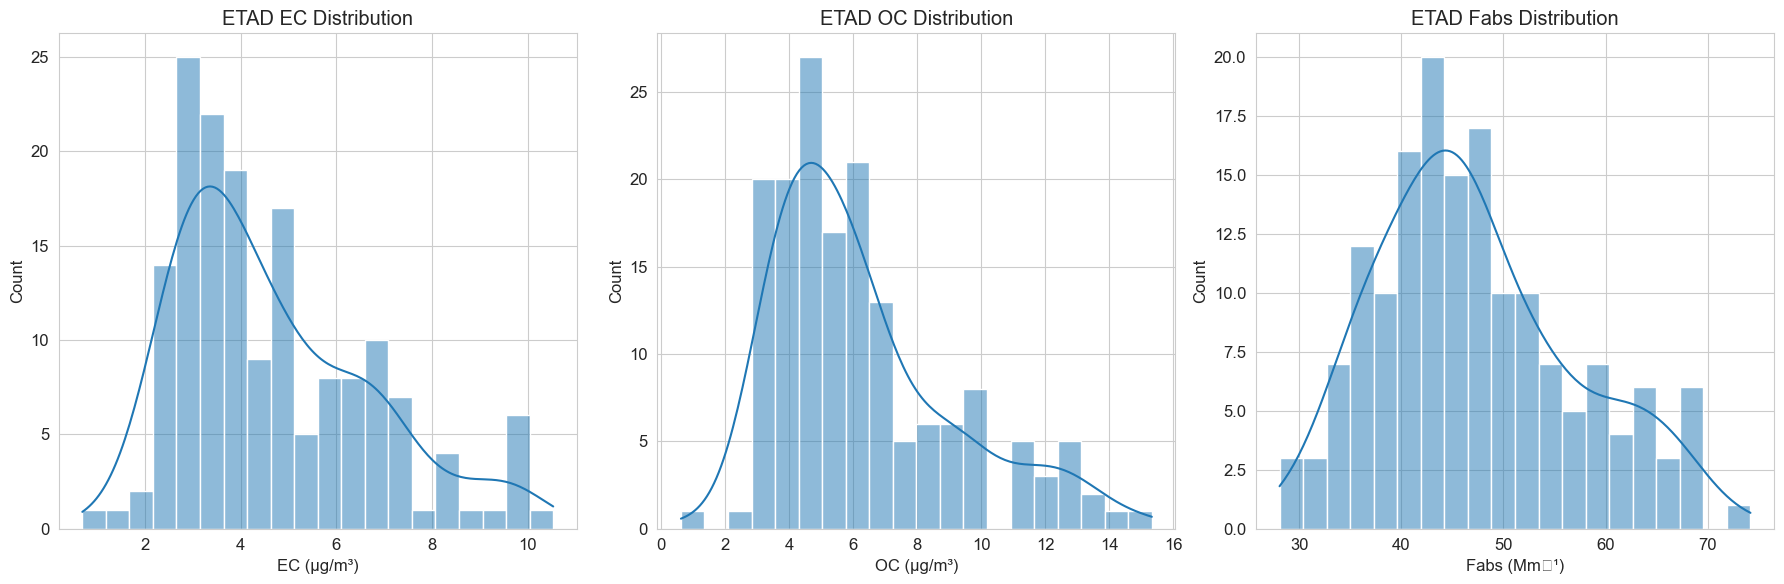

Replaced 1 values below MDL in oc_ftir with MDL/2
Removed 1 samples with extreme values

===== Analysis for Site ETAD =====
Number of samples after processing: 161

----- Time Series Analysis -----


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_25219/2217143362.py:64: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


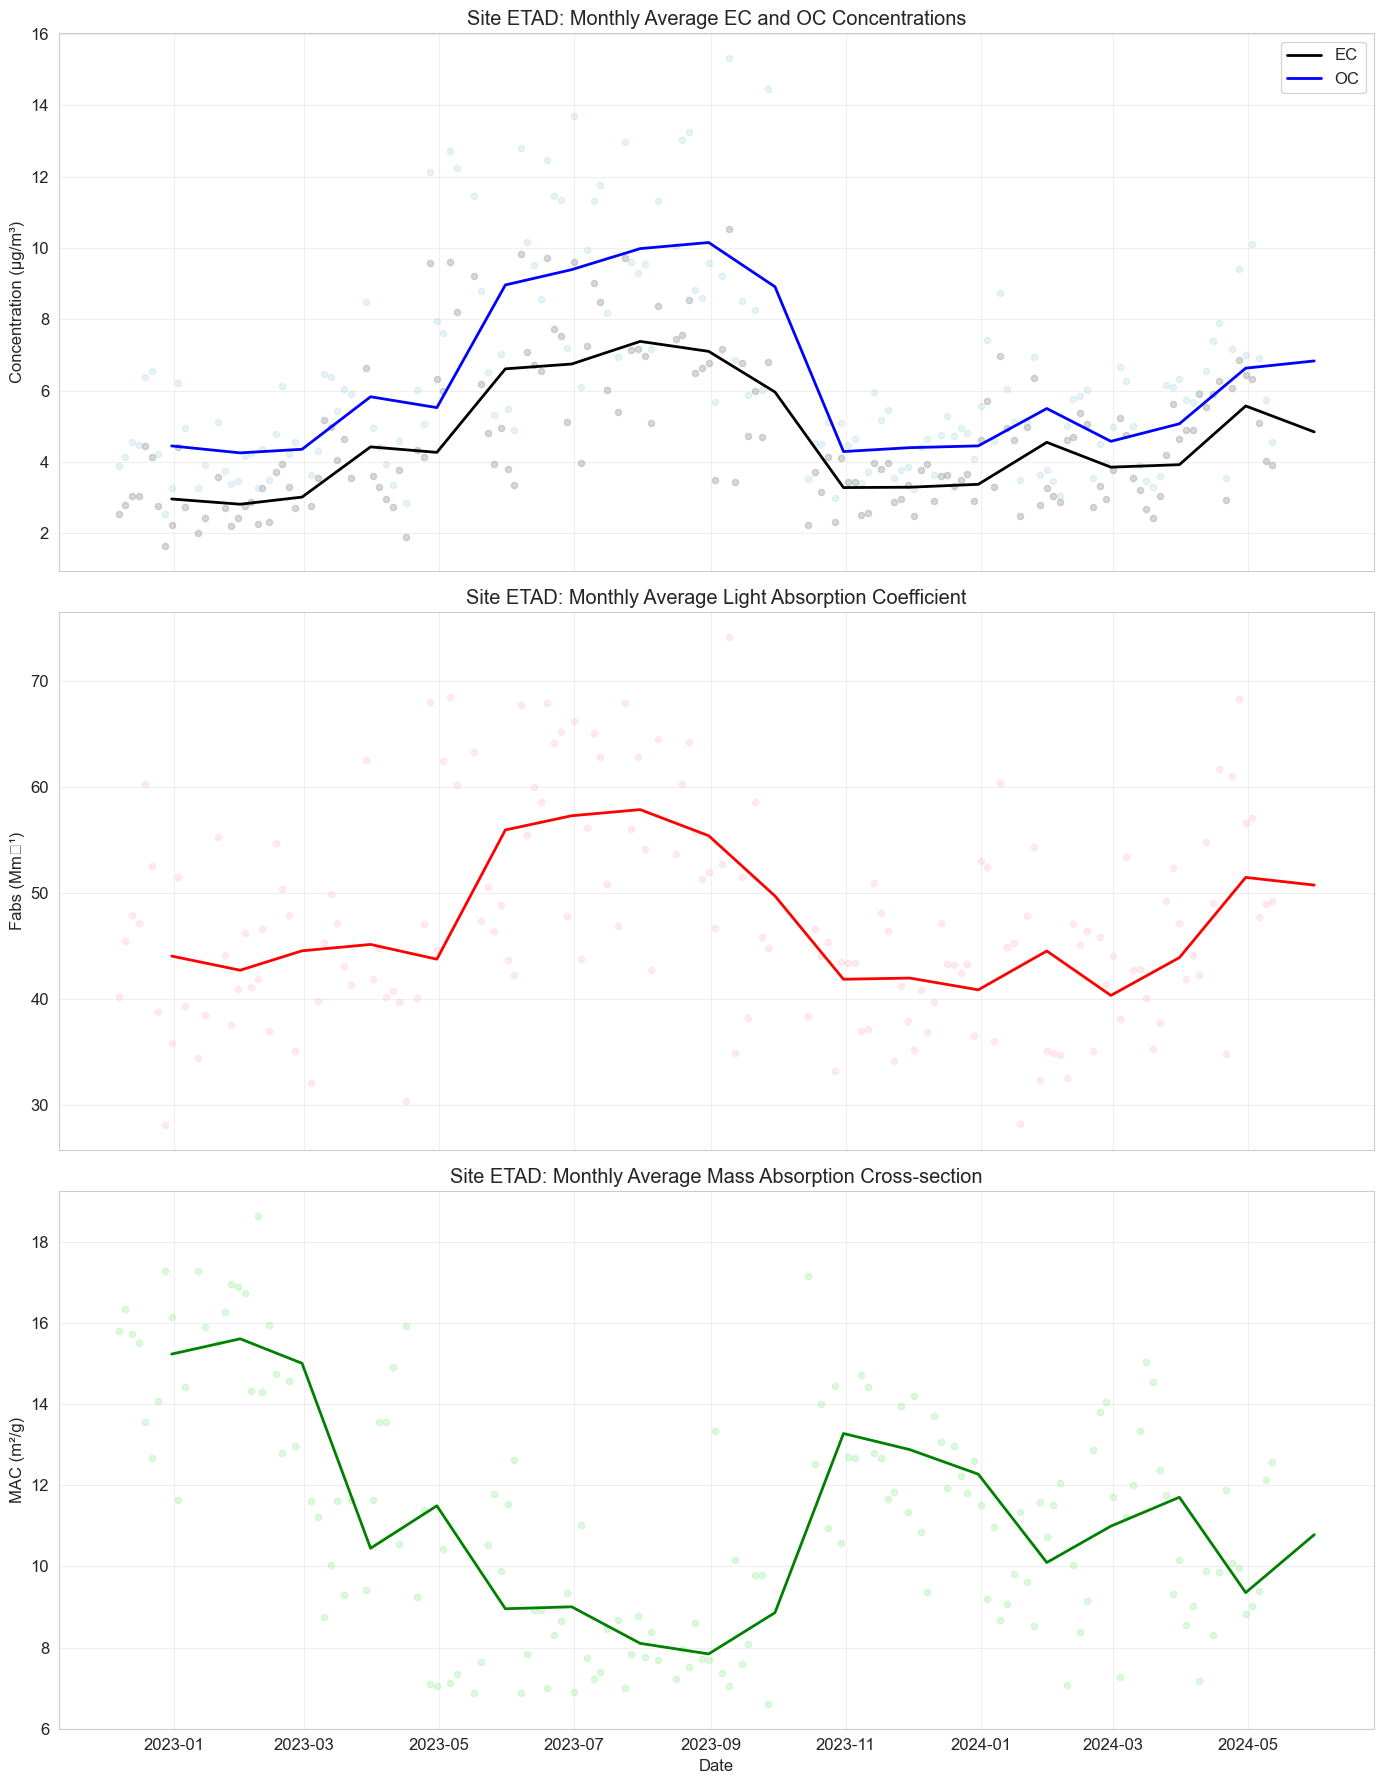


----- Correlation Analysis -----


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_25219/1468801316.py:90: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


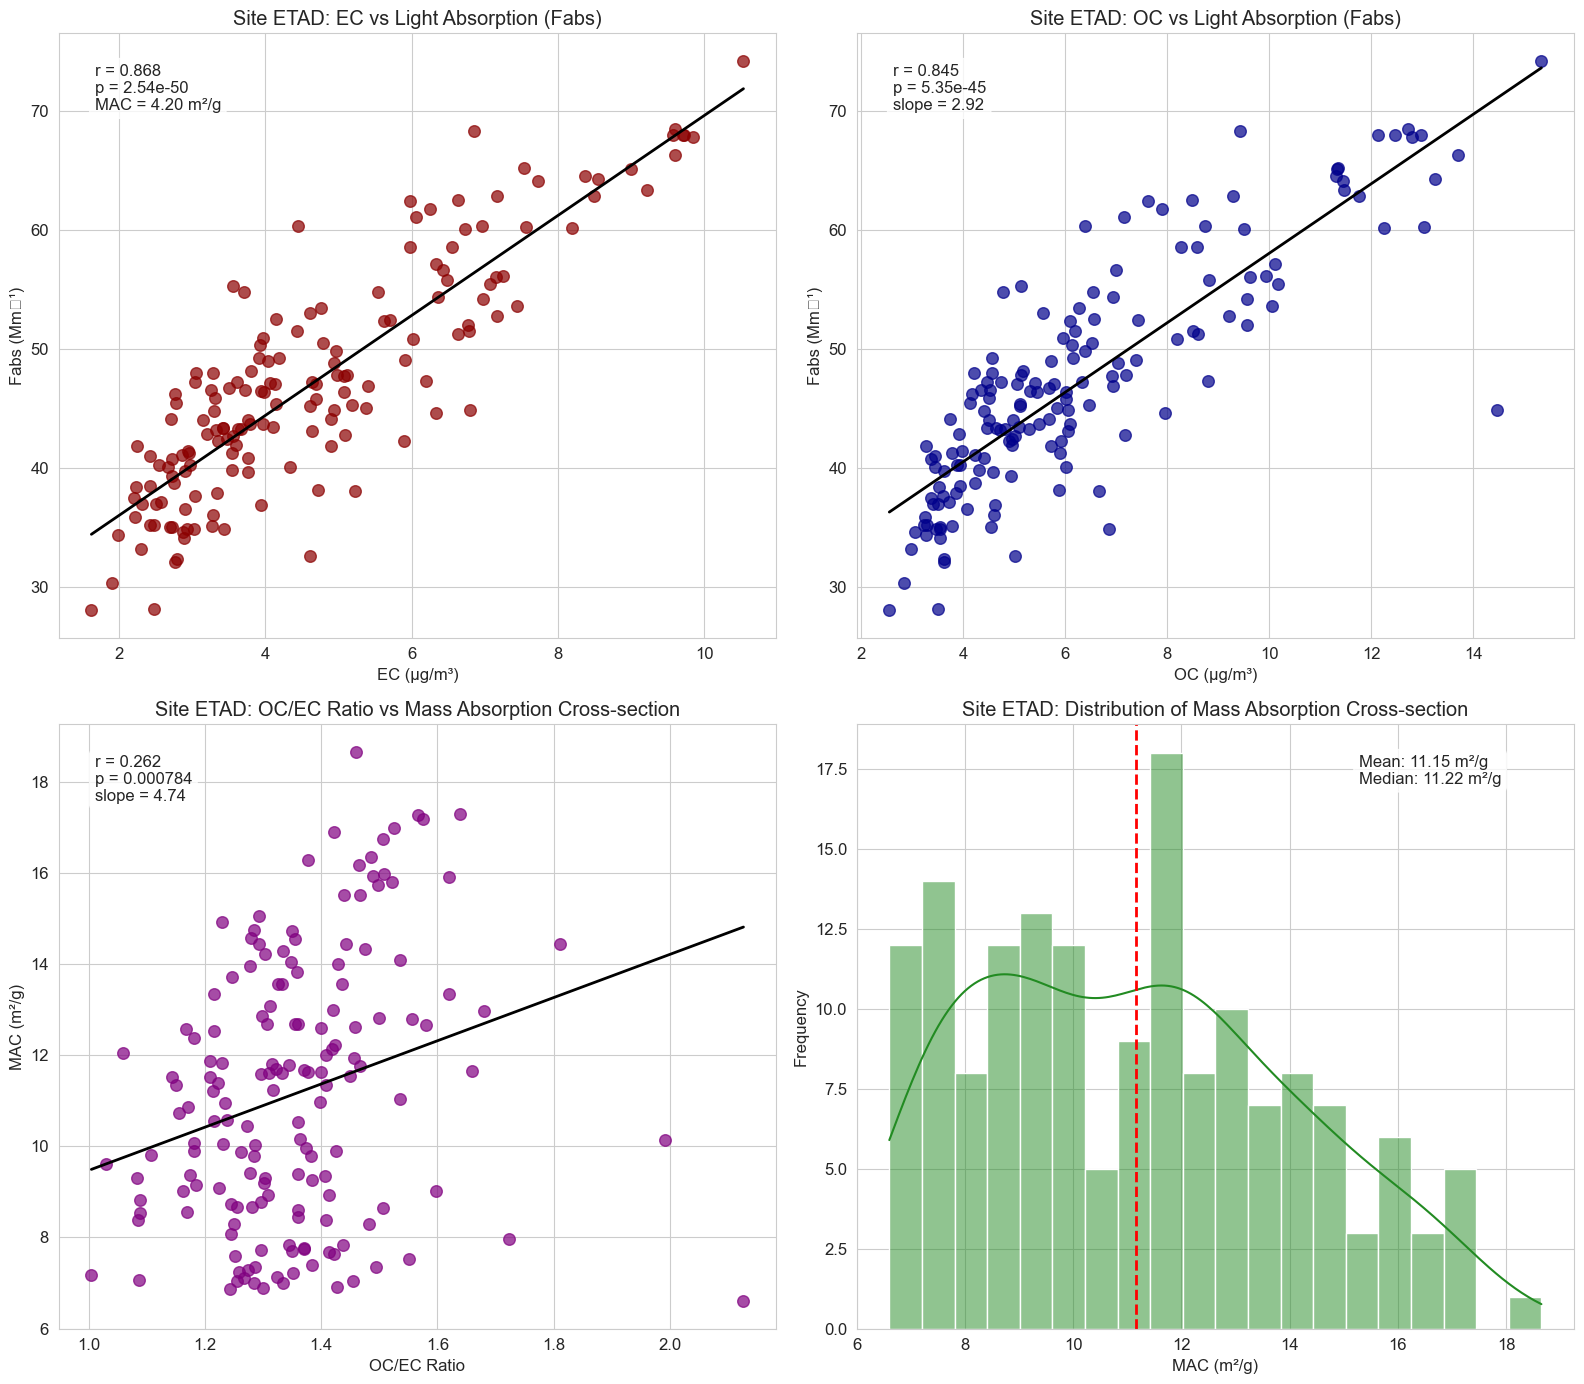


----- Seasonal Analysis -----


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_25219/1767370489.py:83: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_25219/1767370489.py:108: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


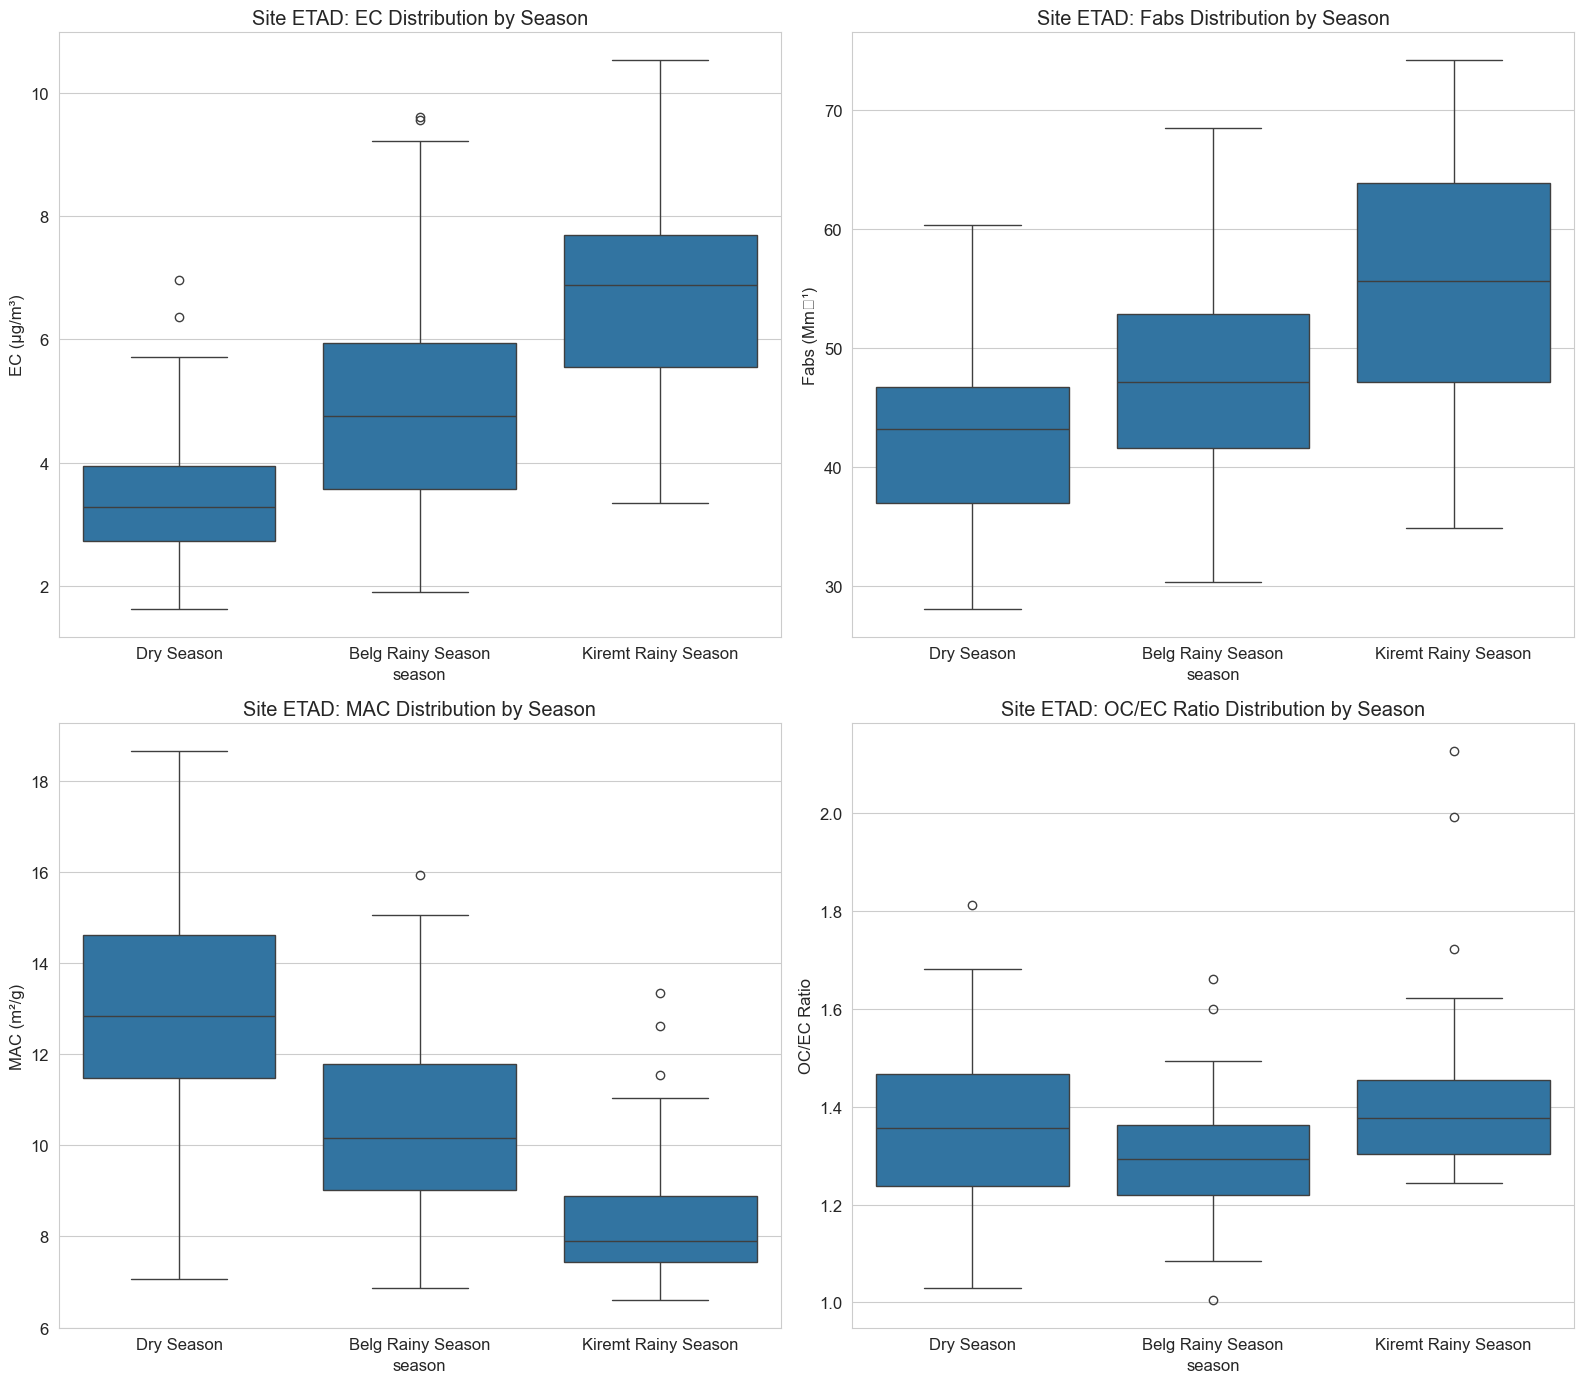

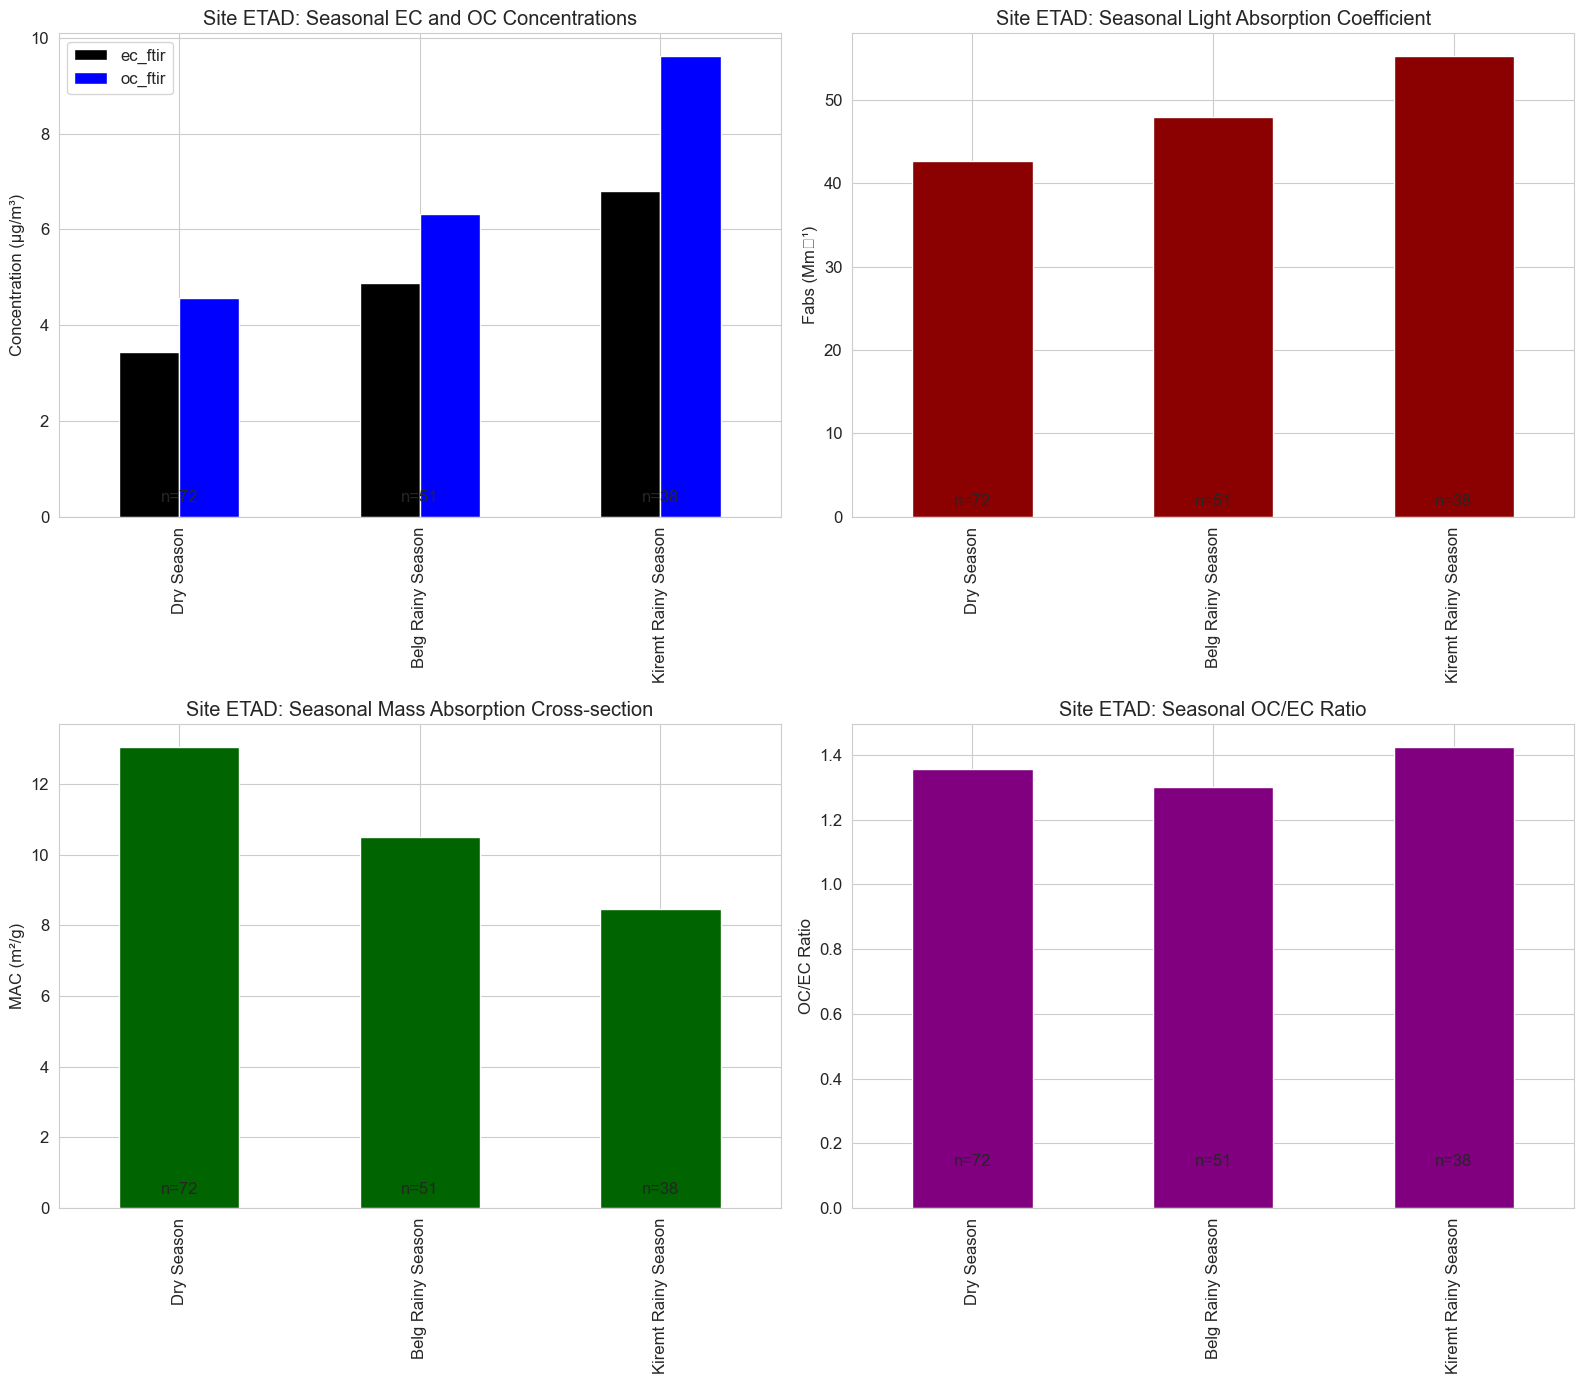

<Figure size 1200x800 with 0 Axes>

/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_25219/3188106965.py:92: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()



----- Trend Analysis -----

===== Trend Summary =====
  Metric    Mean  Annual Change  Percent Change
0     EC   4.125          0.775          18.778
1     OC   5.603          0.565          10.087
2   Fabs  45.997          0.792           1.722
3    MAC  12.285         -2.336         -19.012


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


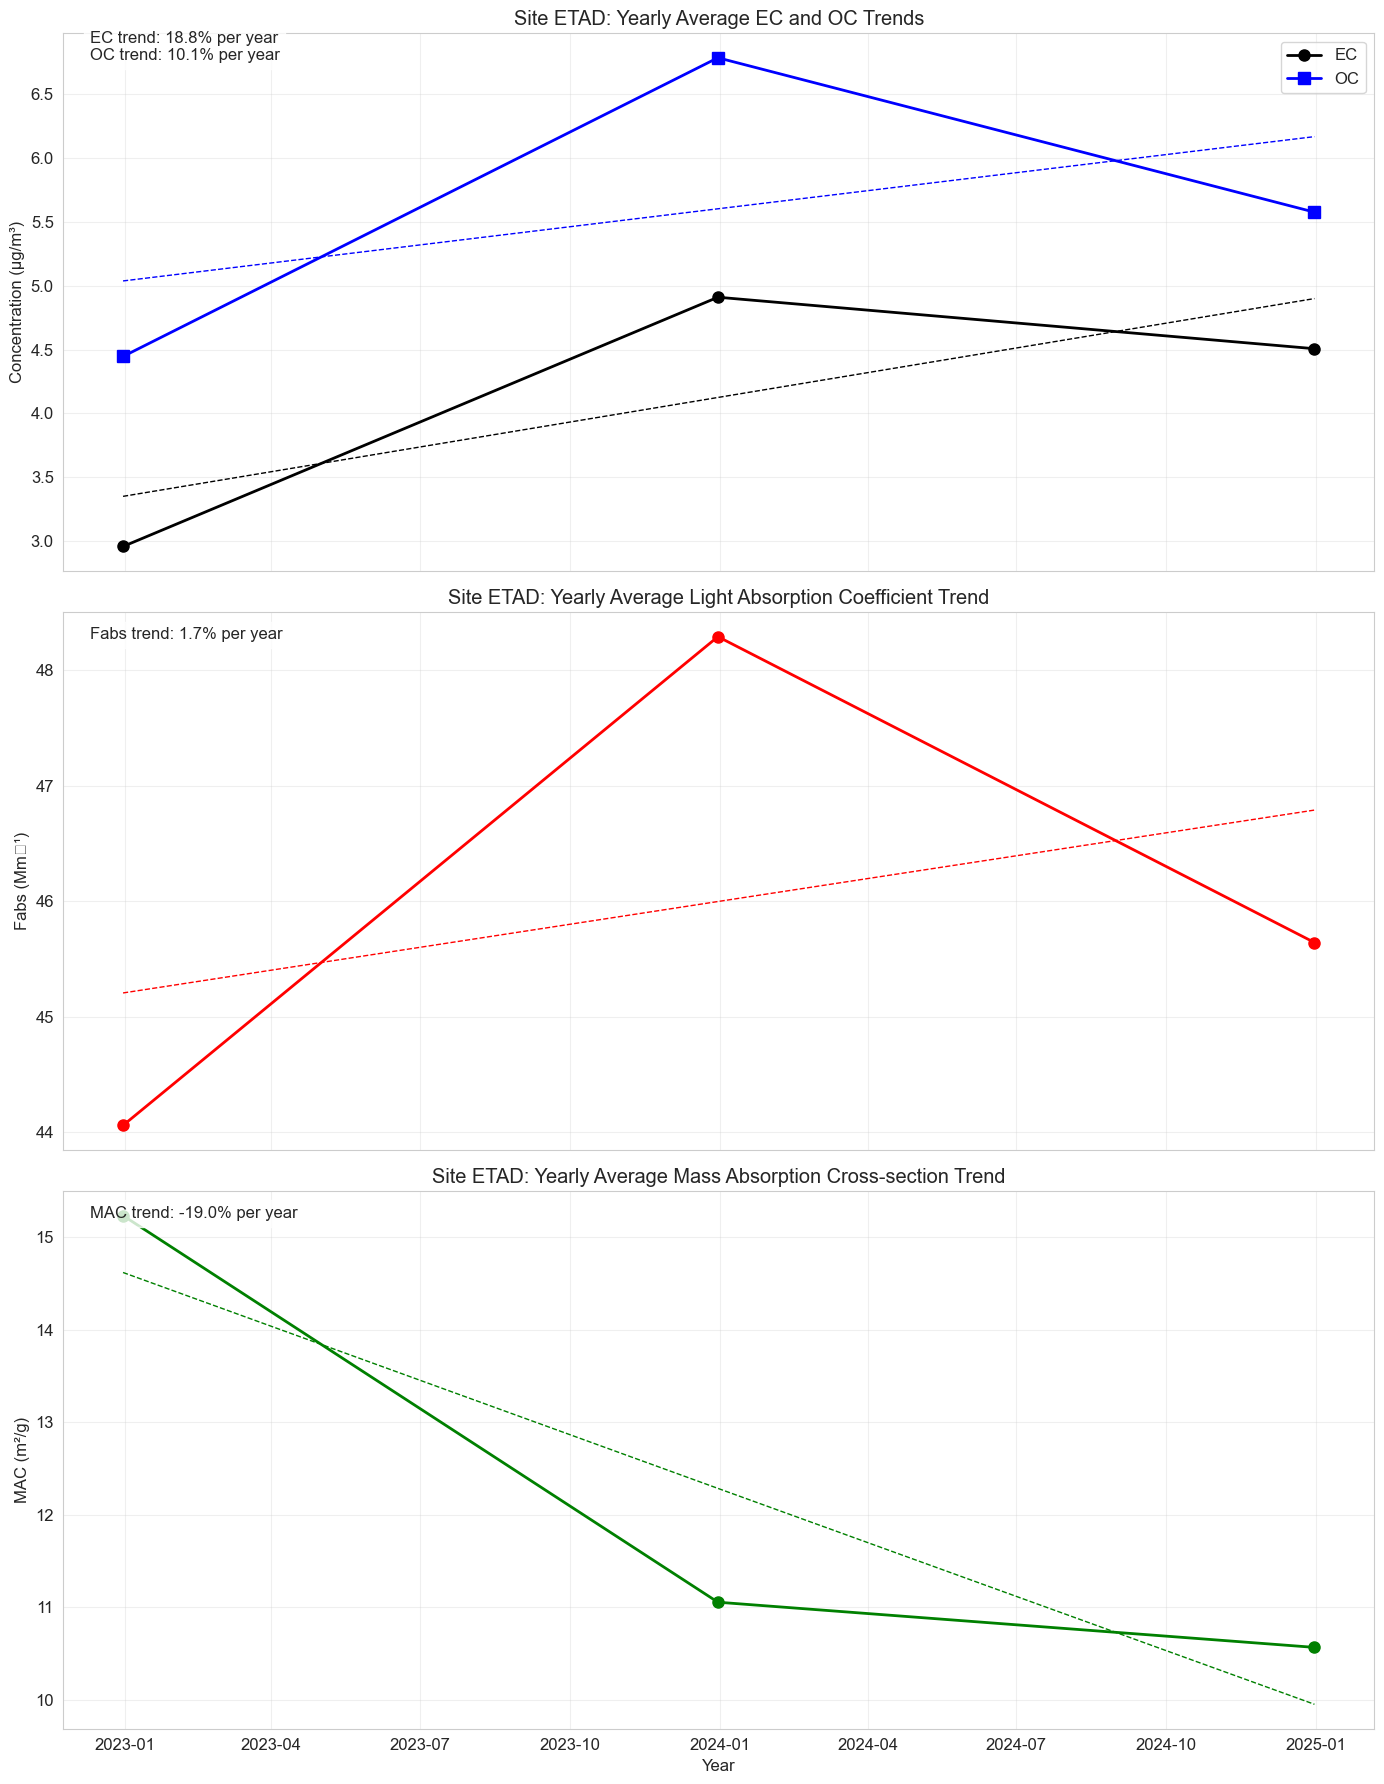


===== Summary Statistics =====

Overall Means:
ec_ftir         4.688
oc_ftir         6.317
fabs           47.314
mac            11.151
oc_ec_ratio     1.355
dtype: float64

Seasonal Means:
                     ec_ftir  oc_ftir    fabs     mac  oc_ec_ratio
season                                                            
Dry Season             3.432    4.569  42.668  13.032        1.357
Belg Rainy Season      4.882    6.330  47.989  10.502        1.300
Kiremt Rainy Season    6.808    9.612  55.210   8.458        1.424


In [12]:
# Main analysis
if __name__ == "__main__":
    # Load data for the specified site
    data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)
    
    if len(data) == 0:
        print(f"No data available for site {SITE_OF_INTEREST}. Please check site code.")
        # You could list available sites or exit here
    else:
        # Explore data
        stats = explore_data(data, SITE_OF_INTEREST)
        
        # Handle values below MDL
        data_processed = handle_mdl_values(data, method='conservative')
        
        # Calculate metrics
        data_metrics = calculate_metrics(data_processed)
        
        print(f"\n===== Analysis for Site {SITE_OF_INTEREST} =====")
        print(f"Number of samples after processing: {len(data_metrics)}")
        
        # Time series analysis
        print("\n----- Time Series Analysis -----")
        fig_ts, monthly_data = analyze_time_series(data_metrics, SITE_OF_INTEREST)
        plt.show()
        
        # Correlation analysis
        print("\n----- Correlation Analysis -----")
        fig_corr = analyze_correlations(data_metrics, SITE_OF_INTEREST)
        plt.show()
        
        # Seasonal analysis
        print("\n----- Seasonal Analysis -----")
        fig_seasonal, seasonal_data = analyze_seasonal_patterns(data_metrics, SITE_OF_INTEREST)
        
        # Trend analysis
        print("\n----- Trend Analysis -----")
        fig_trend, yearly_data = analyze_trends(data_metrics, SITE_OF_INTEREST)
        plt.show()
        
        # Summary statistics
        print("\n===== Summary Statistics =====")
        print("\nOverall Means:")
        print(data_metrics[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean().round(3))
        
        print("\nSeasonal Means:")
        print(seasonal_data[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].round(3))
        

🚀 Running definitive MAC method comparison...

DEFINITIVE MAC METHOD COMPARISON FOR ETAD

📊 MAC VALUES CALCULATED:
Method 1 (Mean of Ratios):  11.15 m²/g
Method 2 (Ratio of Means):  10.09 m²/g
Method 3 (Regression):      4.20 m²/g

📈 BC EQUIVALENT MEANS:
Method 1: 4.24 ± 0.87 μg/m³
Method 2: 4.69 ± 0.97 μg/m³
Method 3: 11.27 ± 2.32 μg/m³
FTIR EC:  4.69 ± 2.02 μg/m³


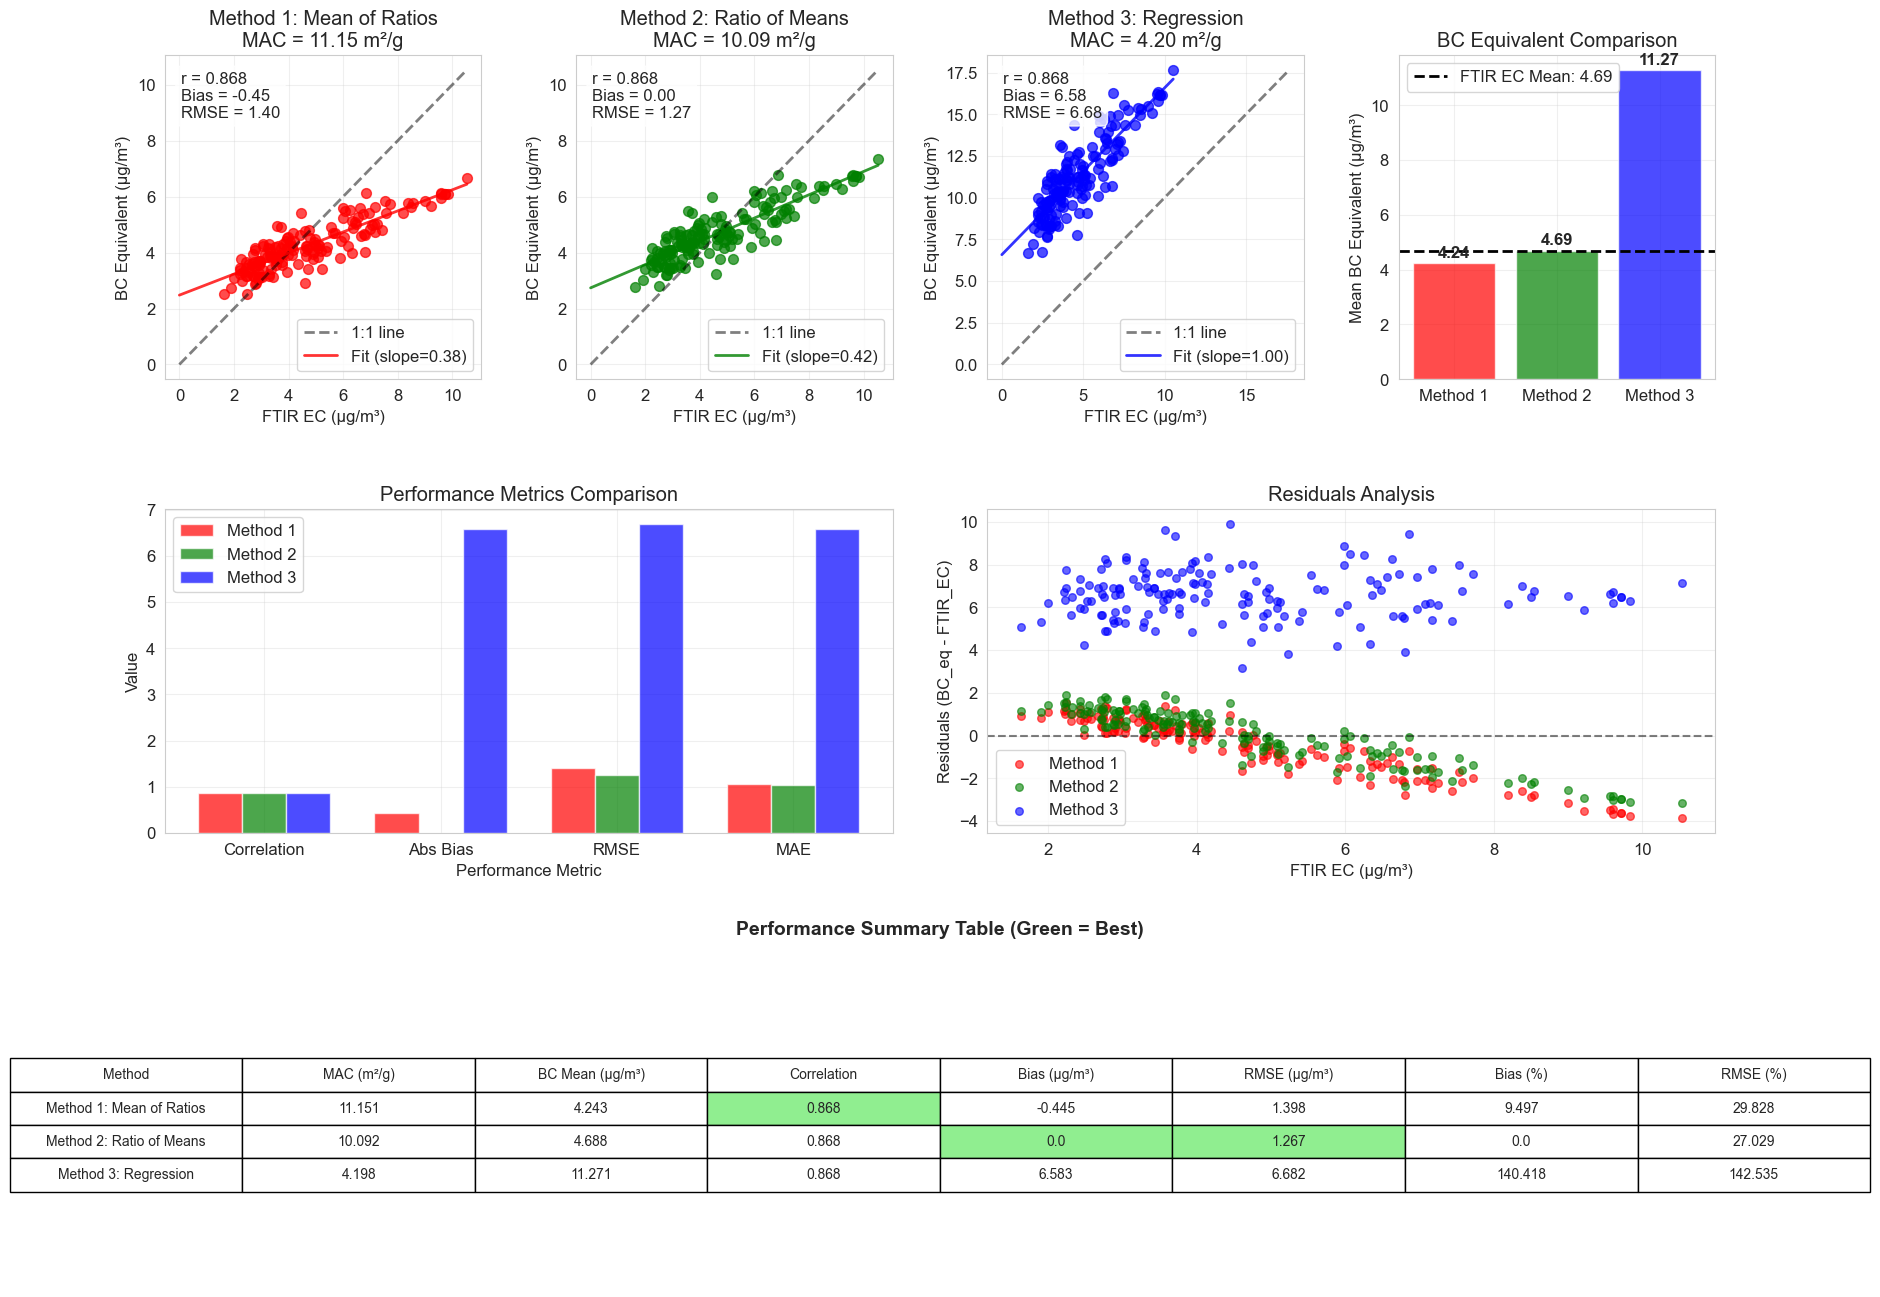


🏆 DETAILED PERFORMANCE ANALYSIS:
Method                    Correlation  Bias       RMSE       MAC       
Method 1 (Mean Ratios)    0.868        -0.45      1.40       11.15     
Method 2 (Ratio Means)    0.868        0.00       1.27       10.09     
Method 3 (Regression)     0.868        6.58       6.68       4.20      

🥇 FINAL RANKING (Best to Worst):
1. Method 2
   MAC = 10.09 m²/g
   Performance: r = 0.868, bias = 0.00, RMSE = 1.27
   Composite Score: 0.660 (lower = better)
   ✅ RECOMMENDED for BC equivalent calculations

2. Method 1
   MAC = 11.15 m²/g
   Performance: r = 0.868, bias = -0.45, RMSE = 1.40
   Composite Score: 0.859 (lower = better)

3. Method 3
   MAC = 4.20 m²/g
   Performance: r = 0.868, bias = 6.58, RMSE = 6.68
   Composite Score: 5.342 (lower = better)


                        🎯 FINAL RECOMMENDATION                        
USE METHOD 2: MAC = 10.09 m²/g

✅ Why this method is best:
   • Correlation with FTIR EC: r = 0.868
   • Bias: 0.00 μg/m³ (0.0%)
   • RMSE: 

In [18]:
# %%
# =============================================================================
# DEFINITIVE MAC METHOD COMPARISON FOR BC EQUIVALENT CALCULATIONS
# =============================================================================
"""
This section definitively compares three methods for calculating MAC values
and determines which is best for converting HIPS light absorption to BC equivalent.

Method 1: Mean of Individual Ratios = mean(Fabs/EC)
Method 2: Ratio of Means = mean(Fabs)/mean(EC) 
Method 3: Regression Slope = slope of Fabs vs EC regression line

The goal is to find which MAC gives BC equivalent values that best match FTIR EC.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def comprehensive_mac_comparison(df, site_code):
    """
    Comprehensive comparison of all three MAC calculation methods
    with definitive performance ranking for BC equivalent calculations
    
    Parameters:
    -----------
    df : DataFrame
        Data with 'fabs', 'ec_ftir' columns
    site_code : str
        Site identifier
        
    Returns:
    --------
    dict : Results and recommendations
    """
    
    print(f"\n{'='*80}")
    print(f"DEFINITIVE MAC METHOD COMPARISON FOR {site_code}")
    print(f"{'='*80}")
    
    # =============================================================================
    # STEP 1: Calculate MAC values using all three methods
    # =============================================================================
    
    # Method 1: Mean of Individual Ratios (your original 11.15 m²/g)
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of Means (the "missing" method ~10.1 m²/g)
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Regression Slope (your original 4.20 m²/g)
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope
    
    print(f"\n📊 MAC VALUES CALCULATED:")
    print(f"Method 1 (Mean of Ratios):  {mac_method1:.2f} m²/g")
    print(f"Method 2 (Ratio of Means):  {mac_method2:.2f} m²/g") 
    print(f"Method 3 (Regression):      {mac_method3:.2f} m²/g")
    
    # =============================================================================
    # STEP 2: Calculate BC equivalent using each MAC
    # =============================================================================
    
    bc_method1 = df['fabs'] / mac_method1
    bc_method2 = df['fabs'] / mac_method2
    bc_method3 = df['fabs'] / mac_method3
    
    print(f"\n📈 BC EQUIVALENT MEANS:")
    print(f"Method 1: {bc_method1.mean():.2f} ± {bc_method1.std():.2f} μg/m³")
    print(f"Method 2: {bc_method2.mean():.2f} ± {bc_method2.std():.2f} μg/m³")
    print(f"Method 3: {bc_method3.mean():.2f} ± {bc_method3.std():.2f} μg/m³")
    print(f"FTIR EC:  {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    
    # =============================================================================
    # STEP 3: Calculate performance metrics vs FTIR EC
    # =============================================================================
    
    def calculate_performance_metrics(bc_equiv, ftir_ec):
        """Calculate comprehensive performance metrics"""
        correlation, p_value = stats.pearsonr(bc_equiv, ftir_ec)
        bias = (bc_equiv - ftir_ec).mean()
        abs_bias = abs(bias)
        rmse = np.sqrt(mean_squared_error(ftir_ec, bc_equiv))
        mae = mean_absolute_error(ftir_ec, bc_equiv)
        
        # Normalized metrics (as % of FTIR EC mean)
        mean_ftir = ftir_ec.mean()
        norm_bias = abs(bias) / mean_ftir * 100
        norm_rmse = rmse / mean_ftir * 100
        
        return {
            'correlation': correlation,
            'p_value': p_value,
            'bias': bias,
            'abs_bias': abs_bias,
            'rmse': rmse,
            'mae': mae,
            'norm_bias_pct': norm_bias,
            'norm_rmse_pct': norm_rmse
        }
    
    metrics1 = calculate_performance_metrics(bc_method1, df['ec_ftir'])
    metrics2 = calculate_performance_metrics(bc_method2, df['ec_ftir'])
    metrics3 = calculate_performance_metrics(bc_method3, df['ec_ftir'])
    
    # =============================================================================
    # STEP 4: Create comprehensive visualization
    # =============================================================================
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)
    
    # Top row: Scatter plots of BC equivalent vs FTIR EC
    methods_data = [
        ('Method 1: Mean of Ratios', bc_method1, metrics1, 'red', mac_method1),
        ('Method 2: Ratio of Means', bc_method2, metrics2, 'green', mac_method2),
        ('Method 3: Regression', bc_method3, metrics3, 'blue', mac_method3)
    ]
    
    for i, (title, bc_data, metrics, color, mac_val) in enumerate(methods_data):
        ax = fig.add_subplot(gs[0, i])
        
        # Scatter plot
        ax.scatter(df['ec_ftir'], bc_data, alpha=0.7, s=50, color=color)
        
        # 1:1 line
        max_val = max(df['ec_ftir'].max(), bc_data.max())
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='1:1 line')
        
        # Regression line
        slope_fit, intercept_fit = np.polyfit(df['ec_ftir'], bc_data, 1)
        x_line = np.linspace(0, df['ec_ftir'].max(), 100)
        ax.plot(x_line, slope_fit * x_line + intercept_fit, color=color, 
                linewidth=2, alpha=0.8, label=f'Fit (slope={slope_fit:.2f})')
        
        ax.set_xlabel('FTIR EC (μg/m³)')
        ax.set_ylabel('BC Equivalent (μg/m³)')
        ax.set_title(f'{title}\nMAC = {mac_val:.2f} m²/g')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add performance metrics text
        ax.text(0.05, 0.95, 
                f'r = {metrics["correlation"]:.3f}\n'
                f'Bias = {metrics["bias"]:.2f}\n'
                f'RMSE = {metrics["rmse"]:.2f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Fourth subplot: Method comparison bar chart
    ax4 = fig.add_subplot(gs[0, 3])
    methods_names = ['Method 1', 'Method 2', 'Method 3']
    bc_means = [bc_method1.mean(), bc_method2.mean(), bc_method3.mean()]
    colors = ['red', 'green', 'blue']
    
    bars = ax4.bar(methods_names, bc_means, color=colors, alpha=0.7)
    ax4.axhline(df['ec_ftir'].mean(), color='black', linestyle='--', linewidth=2,
                label=f'FTIR EC Mean: {df["ec_ftir"].mean():.2f}')
    ax4.set_ylabel('Mean BC Equivalent (μg/m³)')
    ax4.set_title('BC Equivalent Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, value in zip(bars, bc_means):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Middle row: Performance metrics comparison
    ax5 = fig.add_subplot(gs[1, :2])
    
    metrics_names = ['Correlation', 'Abs Bias', 'RMSE', 'MAE']
    method1_vals = [metrics1['correlation'], metrics1['abs_bias'], metrics1['rmse'], metrics1['mae']]
    method2_vals = [metrics2['correlation'], metrics2['abs_bias'], metrics2['rmse'], metrics2['mae']]
    method3_vals = [metrics3['correlation'], metrics3['abs_bias'], metrics3['rmse'], metrics3['mae']]
    
    x = np.arange(len(metrics_names))
    width = 0.25
    
    ax5.bar(x - width, method1_vals, width, label='Method 1', color='red', alpha=0.7)
    ax5.bar(x, method2_vals, width, label='Method 2', color='green', alpha=0.7)
    ax5.bar(x + width, method3_vals, width, label='Method 3', color='blue', alpha=0.7)
    
    ax5.set_xlabel('Performance Metric')
    ax5.set_ylabel('Value')
    ax5.set_title('Performance Metrics Comparison')
    ax5.set_xticks(x)
    ax5.set_xticklabels(metrics_names)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Residuals analysis
    ax6 = fig.add_subplot(gs[1, 2:])
    
    residuals1 = bc_method1 - df['ec_ftir']
    residuals2 = bc_method2 - df['ec_ftir']
    residuals3 = bc_method3 - df['ec_ftir']
    
    ax6.scatter(df['ec_ftir'], residuals1, alpha=0.6, color='red', label='Method 1', s=30)
    ax6.scatter(df['ec_ftir'], residuals2, alpha=0.6, color='green', label='Method 2', s=30)
    ax6.scatter(df['ec_ftir'], residuals3, alpha=0.6, color='blue', label='Method 3', s=30)
    ax6.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    ax6.set_xlabel('FTIR EC (μg/m³)')
    ax6.set_ylabel('Residuals (BC_eq - FTIR_EC)')
    ax6.set_title('Residuals Analysis')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Bottom row: Detailed performance table
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('tight')
    ax7.axis('off')
    
    # Create performance summary table
    performance_data = {
        'Method': ['Method 1: Mean of Ratios', 'Method 2: Ratio of Means', 'Method 3: Regression'],
        'MAC (m²/g)': [mac_method1, mac_method2, mac_method3],
        'BC Mean (μg/m³)': [bc_method1.mean(), bc_method2.mean(), bc_method3.mean()],
        'Correlation': [metrics1['correlation'], metrics2['correlation'], metrics3['correlation']],
        'Bias (μg/m³)': [metrics1['bias'], metrics2['bias'], metrics3['bias']],
        'RMSE (μg/m³)': [metrics1['rmse'], metrics2['rmse'], metrics3['rmse']],
        'Bias (%)': [metrics1['norm_bias_pct'], metrics2['norm_bias_pct'], metrics3['norm_bias_pct']],
        'RMSE (%)': [metrics1['norm_rmse_pct'], metrics2['norm_rmse_pct'], metrics3['norm_rmse_pct']]
    }
    
    perf_df = pd.DataFrame(performance_data)
    
    # Round numerical columns
    for col in ['MAC (m²/g)', 'BC Mean (μg/m³)', 'Correlation', 'Bias (μg/m³)', 'RMSE (μg/m³)', 'Bias (%)', 'RMSE (%)']:
        perf_df[col] = perf_df[col].round(3)
    
    table = ax7.table(cellText=perf_df.values,
                      colLabels=perf_df.columns,
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Color code the best values in each column
    best_corr_idx = perf_df['Correlation'].idxmax()
    best_bias_idx = perf_df['Bias (μg/m³)'].abs().idxmin()
    best_rmse_idx = perf_df['RMSE (μg/m³)'].idxmin()
    
    # Highlight best performance
    for i in range(len(perf_df)):
        if i == best_corr_idx:
            table[(i+1, 3)].set_facecolor('#90EE90')  # Light green for best correlation
        if i == best_bias_idx:
            table[(i+1, 4)].set_facecolor('#90EE90')  # Light green for best bias
        if i == best_rmse_idx:
            table[(i+1, 5)].set_facecolor('#90EE90')  # Light green for best RMSE
    
    ax7.set_title('Performance Summary Table (Green = Best)', pad=20, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # STEP 5: Ranking and final recommendation
    # =============================================================================
    
    print(f"\n🏆 DETAILED PERFORMANCE ANALYSIS:")
    print(f"{'Method':<25} {'Correlation':<12} {'Bias':<10} {'RMSE':<10} {'MAC':<10}")
    print(f"{'='*70}")
    print(f"{'Method 1 (Mean Ratios)':<25} {metrics1['correlation']:<12.3f} {metrics1['bias']:<10.2f} {metrics1['rmse']:<10.2f} {mac_method1:<10.2f}")
    print(f"{'Method 2 (Ratio Means)':<25} {metrics2['correlation']:<12.3f} {metrics2['bias']:<10.2f} {metrics2['rmse']:<10.2f} {mac_method2:<10.2f}")
    print(f"{'Method 3 (Regression)':<25} {metrics3['correlation']:<12.3f} {metrics3['bias']:<10.2f} {metrics3['rmse']:<10.2f} {mac_method3:<10.2f}")
    
    # Calculate composite score (lower is better)
    # Weight: 50% RMSE, 30% absolute bias, 20% correlation (inverted)
    def composite_score(metrics):
        return (0.5 * metrics['rmse'] + 
                0.3 * metrics['abs_bias'] + 
                0.2 * (1 - metrics['correlation']))
    
    score1 = composite_score(metrics1)
    score2 = composite_score(metrics2) 
    score3 = composite_score(metrics3)
    
    methods_ranked = [
        ('Method 1', mac_method1, score1, metrics1),
        ('Method 2', mac_method2, score2, metrics2),
        ('Method 3', mac_method3, score3, metrics3)
    ]
    
    # Sort by composite score (lower is better)
    methods_ranked.sort(key=lambda x: x[2])
    
    print(f"\n🥇 FINAL RANKING (Best to Worst):")
    print(f"{'='*70}")
    
    for i, (method, mac, score, metrics) in enumerate(methods_ranked, 1):
        print(f"{i}. {method}")
        print(f"   MAC = {mac:.2f} m²/g")
        print(f"   Performance: r = {metrics['correlation']:.3f}, bias = {metrics['bias']:.2f}, RMSE = {metrics['rmse']:.2f}")
        print(f"   Composite Score: {score:.3f} (lower = better)")
        
        if i == 1:
            print(f"   ✅ RECOMMENDED for BC equivalent calculations")
            recommended_method = method
            recommended_mac = mac
            recommended_metrics = metrics
        print()
    
    # =============================================================================
    # STEP 6: Final recommendation summary
    # =============================================================================
    
    print(f"\n{'🎯 FINAL RECOMMENDATION':^70}")
    print(f"{'='*70}")
    print(f"USE {recommended_method.upper()}: MAC = {recommended_mac:.2f} m²/g")
    print(f"\n✅ Why this method is best:")
    print(f"   • Correlation with FTIR EC: r = {recommended_metrics['correlation']:.3f}")
    print(f"   • Bias: {recommended_metrics['bias']:.2f} μg/m³ ({recommended_metrics['norm_bias_pct']:.1f}%)")
    print(f"   • RMSE: {recommended_metrics['rmse']:.2f} μg/m³ ({recommended_metrics['norm_rmse_pct']:.1f}%)")
    
    print(f"\n📋 Practical Implementation:")
    print(f"   BC_equivalent = Fabs / {recommended_mac:.2f}  # in m²/g")
    print(f"   Example: For Fabs = 45 Mm⁻¹ → BC = {45/recommended_mac:.2f} μg/m³")
    
    print(f"\n📝 For your paper:")
    print(f'   "BC equivalent concentrations were calculated from HIPS light absorption')
    print(f'   measurements using MAC = {recommended_mac:.2f} m²/g ({recommended_method.lower()}).')
    print(f'   This approach achieved excellent correlation (r = {recommended_metrics["correlation"]:.3f}, p < 0.001)')
    print(f'   with minimal bias ({recommended_metrics["bias"]:.2f} μg/m³) and RMSE ({recommended_metrics["rmse"]:.2f} μg/m³)')
    print(f'   compared to FTIR EC measurements."')
    
    return {
        'recommended_method': recommended_method,
        'recommended_mac': recommended_mac,
        'all_methods': methods_ranked,
        'performance_metrics': {
            'method1': metrics1,
            'method2': metrics2, 
            'method3': metrics3
        },
        'bc_equivalents': {
            'method1': bc_method1,
            'method2': bc_method2,
            'method3': bc_method3
        }
    }

# =============================================================================
# RUN THE DEFINITIVE COMPARISON
# =============================================================================

# Run the comprehensive analysis
print("🚀 Running definitive MAC method comparison...")
results = comprehensive_mac_comparison(data_metrics, SITE_OF_INTEREST)

# Store the recommended values for future use
RECOMMENDED_MAC = results['recommended_mac']
RECOMMENDED_METHOD = results['recommended_method']

print(f"\n🎉 Analysis complete! Use MAC = {RECOMMENDED_MAC:.2f} m²/g for BC equivalent calculations.")

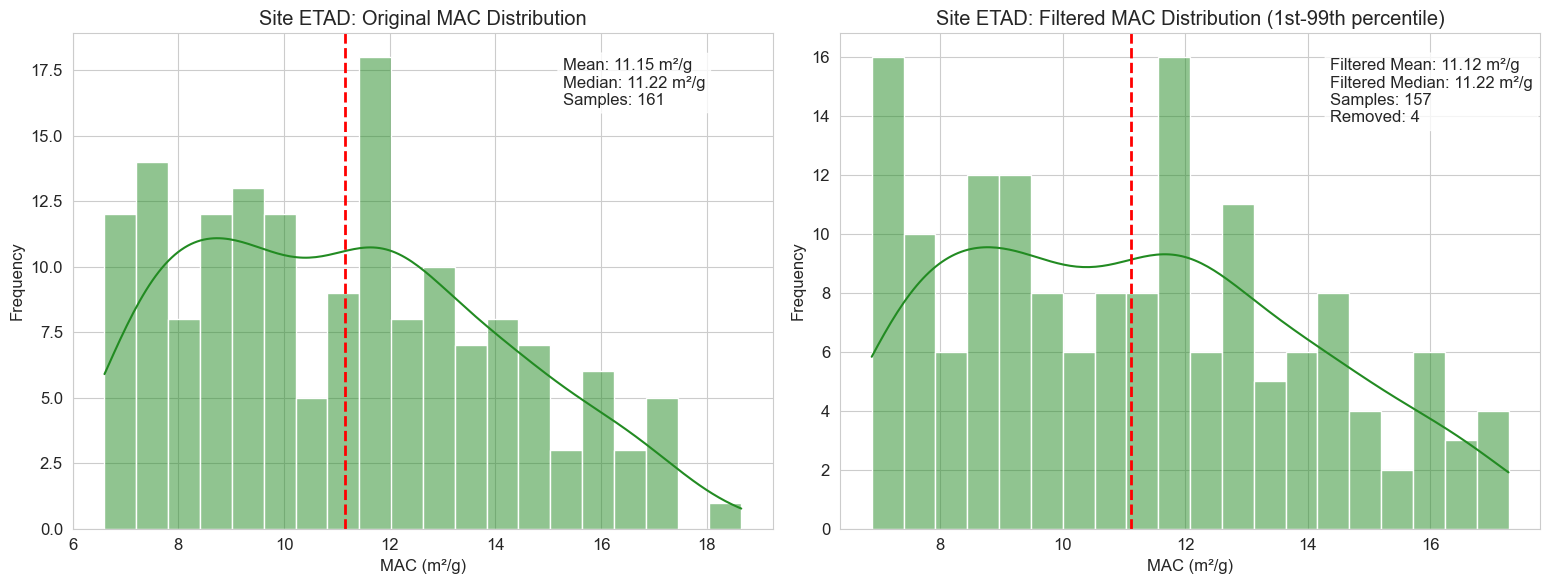


===== MAC Distribution Comparison =====
Original MAC mean: 11.15 m²/g
Filtered MAC mean: 11.12 m²/g
Regression slope MAC: 4.20 m²/g (from your plot)
Samples removed: 4 out of 161
Percentile range removed: < 6.9 and > 17.3 m²/g


In [13]:
# Modified correlation analysis function with outlier removal for MAC distribution
def analyze_correlations_filtered(df, site_code):
    """
    Analyze correlations between key metrics for a specific site
    with outlier removal for MAC distribution
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Correlation analysis plot figure
    """
    
    # Create correlation scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC vs Fabs (unchanged)
    ax1 = axes[0, 0]
    ax1.scatter(df['ec_ftir'], df['fabs'], alpha=0.7, s=70, c='darkred')
    ax1.set_xlabel('EC (μg/m³)')
    ax1.set_ylabel('Fabs (Mm⁻¹)')
    ax1.set_title(f'Site {site_code}: EC vs Light Absorption (Fabs)')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['ec_ftir'], df['fabs'], 1)
        x_line = np.linspace(df['ec_ftir'].min(), df['ec_ftir'].max(), 100)
        ax1.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['ec_ftir'], df['fabs'])
        ax1.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nMAC = {m:.2f} m²/g', 
                 transform=ax1.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # OC vs Fabs (unchanged)
    ax2 = axes[0, 1]
    ax2.scatter(df['oc_ftir'], df['fabs'], alpha=0.7, s=70, c='darkblue')
    ax2.set_xlabel('OC (μg/m³)')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: OC vs Light Absorption (Fabs)')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['oc_ftir'], df['fabs'], 1)
        x_line = np.linspace(df['oc_ftir'].min(), df['oc_ftir'].max(), 100)
        ax2.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['oc_ftir'], df['fabs'])
        ax2.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nslope = {m:.2f}', 
                 transform=ax2.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # OC/EC ratio vs MAC (unchanged)
    ax3 = axes[1, 0]
    ax3.scatter(df['oc_ec_ratio'], df['mac'], alpha=0.7, s=70, c='purple')
    ax3.set_xlabel('OC/EC Ratio')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'Site {site_code}: OC/EC Ratio vs Mass Absorption Cross-section')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['oc_ec_ratio'], df['mac'], 1)
        x_line = np.linspace(df['oc_ec_ratio'].min(), df['oc_ec_ratio'].max(), 100)
        ax3.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['oc_ec_ratio'], df['mac'])
        ax3.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nslope = {m:.2f}', 
                 transform=ax3.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # MAC distribution with outlier removal (MODIFIED)
    ax4 = axes[1, 1]
    
    # Calculate percentiles for outlier removal
    p1 = np.percentile(df['mac'], 1)
    p99 = np.percentile(df['mac'], 99)
    
    # Filter data to remove 1st and 99th percentiles
    mac_filtered = df['mac'][(df['mac'] >= p1) & (df['mac'] <= p99)]
    
    # Plot filtered distribution
    sns.histplot(mac_filtered, bins=20, kde=True, ax=ax4, color='forestgreen')
    ax4.set_xlabel('MAC (m²/g)')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Site {site_code}: MAC Distribution (1st-99th percentile)')
    
    # Add mean line for filtered data
    ax4.axvline(mac_filtered.mean(), color='red', linestyle='--', linewidth=2)
    
    # Add statistics text box
    ax4.text(0.7, 0.95, 
             f'Filtered Mean: {mac_filtered.mean():.2f} m²/g\n'
             f'Filtered Median: {mac_filtered.median():.2f} m²/g\n'
             f'Original Mean: {df["mac"].mean():.2f} m²/g\n'
             f'Removed: {len(df) - len(mac_filtered)} samples\n'
             f'Range: {p1:.1f} - {p99:.1f} m²/g', 
             transform=ax4.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    return fig, mac_filtered

# Alternative: Just create the filtered MAC distribution plot
def plot_mac_distribution_comparison(df, site_code):
    """
    Compare MAC distributions with and without outliers
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Original distribution
    ax1 = axes[0]
    sns.histplot(df['mac'], bins=20, kde=True, ax=ax1, color='forestgreen')
    ax1.set_xlabel('MAC (m²/g)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Site {site_code}: Original MAC Distribution')
    ax1.axvline(df['mac'].mean(), color='red', linestyle='--', linewidth=2)
    ax1.text(0.7, 0.95, 
             f'Mean: {df["mac"].mean():.2f} m²/g\n'
             f'Median: {df["mac"].median():.2f} m²/g\n'
             f'Samples: {len(df)}', 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Filtered distribution (remove 1st and 99th percentiles)
    ax2 = axes[1]
    p1 = np.percentile(df['mac'], 1)
    p99 = np.percentile(df['mac'], 99)
    mac_filtered = df['mac'][(df['mac'] >= p1) & (df['mac'] <= p99)]
    
    sns.histplot(mac_filtered, bins=20, kde=True, ax=ax2, color='forestgreen')
    ax2.set_xlabel('MAC (m²/g)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Site {site_code}: Filtered MAC Distribution (1st-99th percentile)')
    ax2.axvline(mac_filtered.mean(), color='red', linestyle='--', linewidth=2)
    ax2.text(0.7, 0.95, 
             f'Filtered Mean: {mac_filtered.mean():.2f} m²/g\n'
             f'Filtered Median: {mac_filtered.median():.2f} m²/g\n'
             f'Samples: {len(mac_filtered)}\n'
             f'Removed: {len(df) - len(mac_filtered)}', 
             transform=ax2.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n===== MAC Distribution Comparison =====")
    print(f"Original MAC mean: {df['mac'].mean():.2f} m²/g")
    print(f"Filtered MAC mean: {mac_filtered.mean():.2f} m²/g")
    print(f"Regression slope MAC: 4.20 m²/g (from your plot)")
    print(f"Samples removed: {len(df) - len(mac_filtered)} out of {len(df)}")
    print(f"Percentile range removed: < {p1:.1f} and > {p99:.1f} m²/g")
    
    return mac_filtered

# Usage examples:
# For your existing analysis, replace the correlation function call:
# fig_corr = analyze_correlations(data_metrics, SITE_OF_INTEREST)
# with:
# fig_corr, mac_filtered = analyze_correlations_filtered(data_metrics, SITE_OF_INTEREST)

# Or just run the comparison:
mac_filtered = plot_mac_distribution_comparison(data_metrics, SITE_OF_INTEREST)

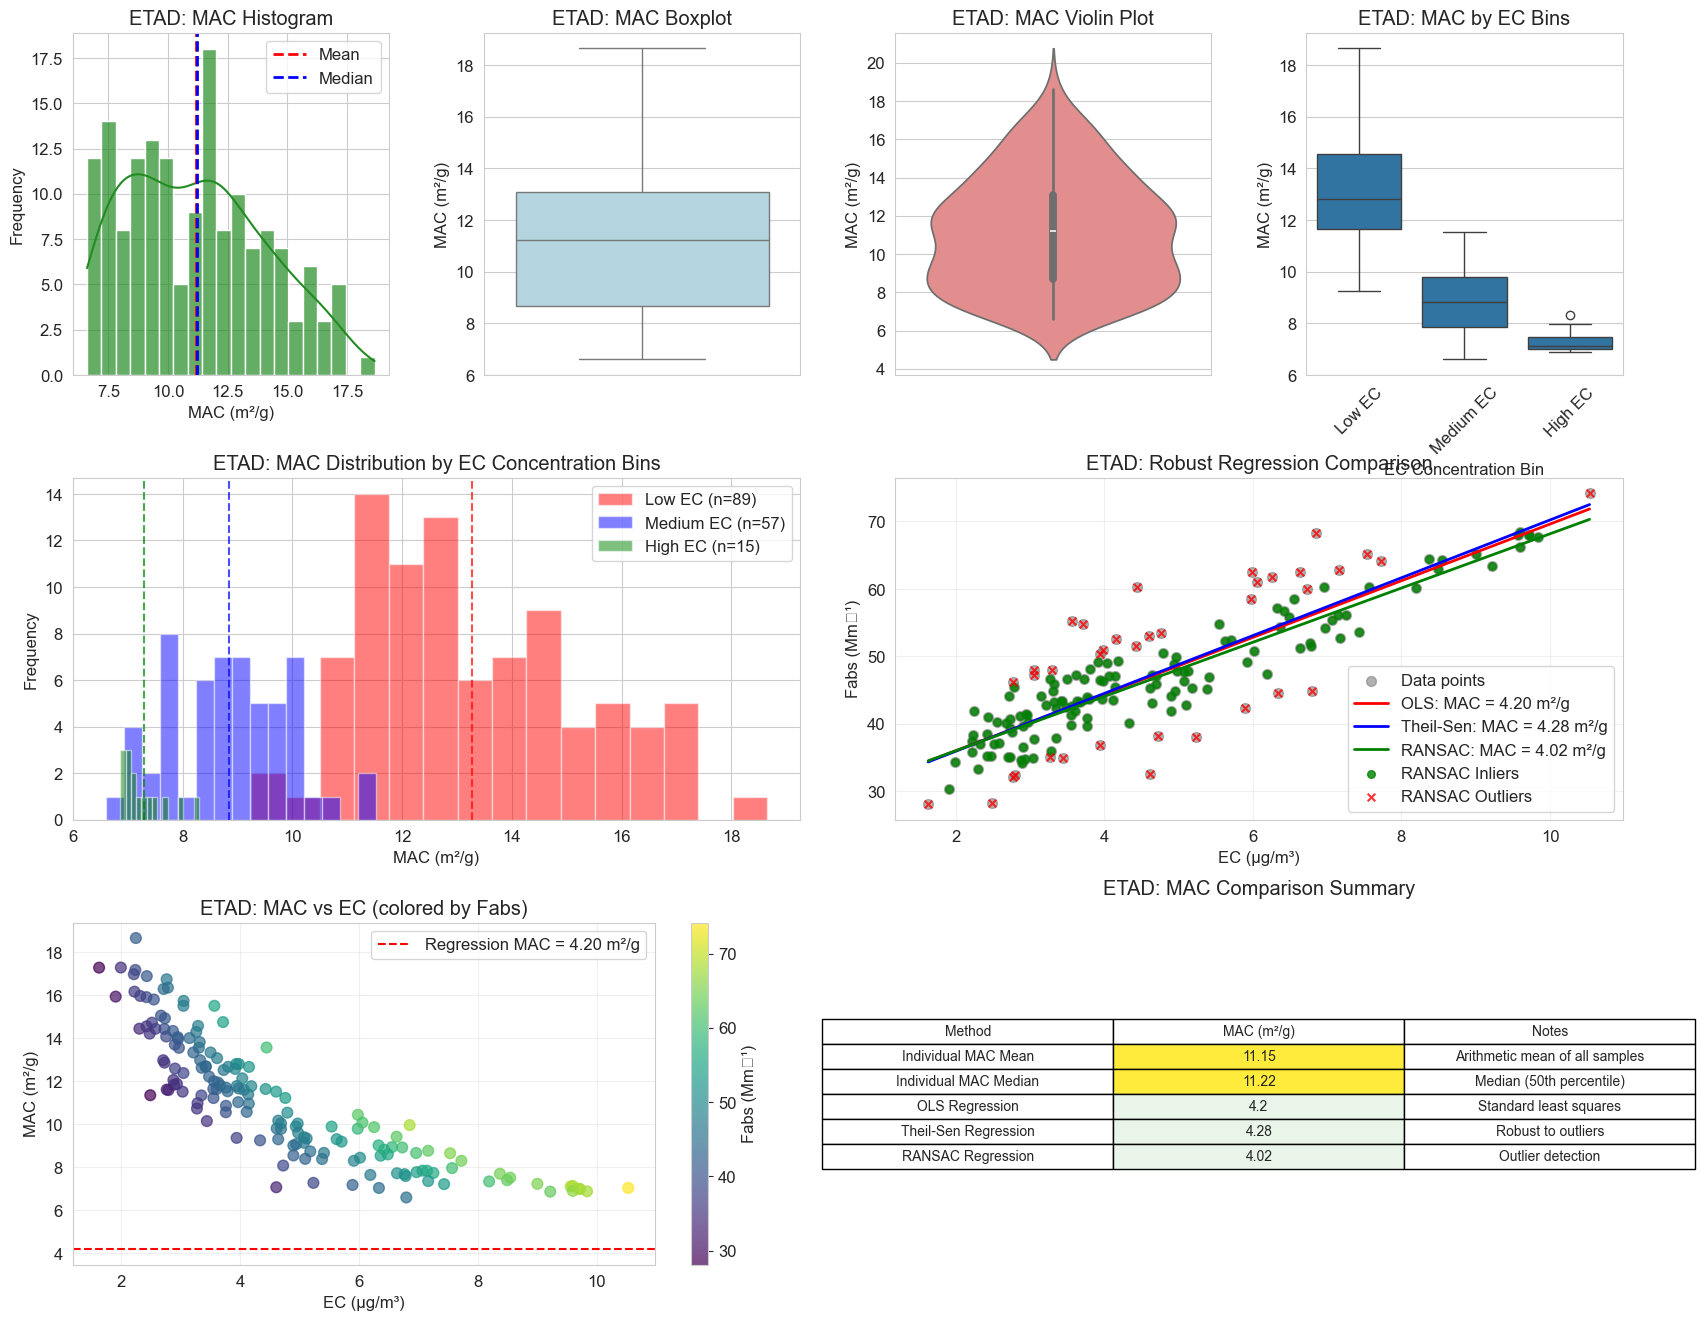


===== ETAD Advanced MAC Analysis =====

--- EC Binning Results ---
Low EC range: (1.617, 4.595]
Medium EC range: (4.595, 7.564]
High EC range: (7.564, 10.533]

MAC statistics by EC bin:
Low EC    : Mean=13.28, Median=12.80, Std=2.02, n=89
Medium EC : Mean=8.84, Median=8.82, Std=1.09, n=57
High EC   : Mean=7.29, Median=7.14, Std=0.42, n=15

--- Robust Regression Comparison ---
OLS Regression MAC:       4.198 m²/g
Theil-Sen Robust MAC:     4.282 m²/g
RANSAC Robust MAC:        4.016 m²/g
RANSAC Outliers detected: 37 out of 161 samples

--- Distribution Summary ---
Individual MAC mean:      11.151 m²/g
Individual MAC median:    11.219 m²/g
Individual MAC std:       2.914 m²/g
MAC range:                6.6 - 18.7 m²/g


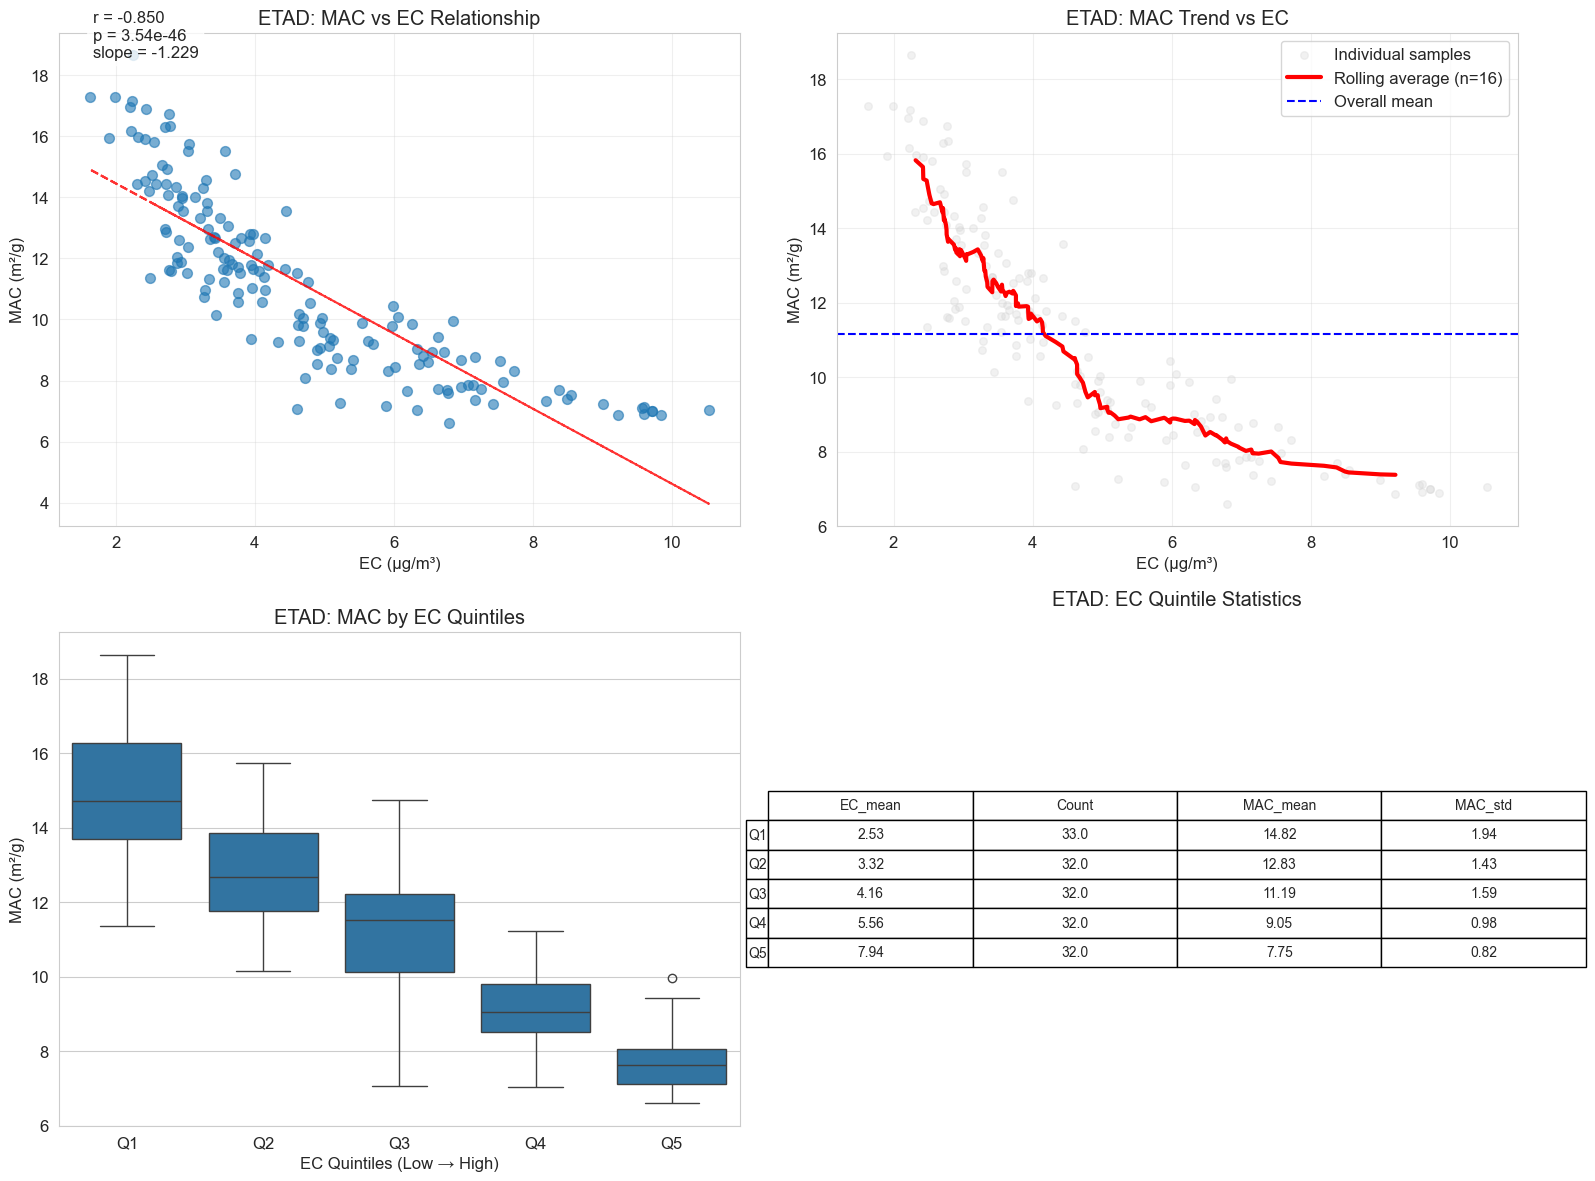


===== MAC vs EC Relationship Analysis =====
Correlation between MAC and EC: r = -0.850, p = 3.54e-46
MAC trend with EC: -1.229 (m²/g) per (μg/m³) EC
→ MAC DECREASES with increasing EC (expected for mixing/coating)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

def advanced_mac_analysis(df, site_code):
    """
    Comprehensive MAC analysis with boxplots, EC binning, and robust regression
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
    """
    
    # Create the main figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. MAC Distribution Comparison (Histogram vs Boxplot vs Violin)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df['mac'], bins=20, kde=True, ax=ax1, color='forestgreen', alpha=0.7)
    ax1.axvline(df['mac'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax1.axvline(df['mac'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
    ax1.set_xlabel('MAC (m²/g)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{site_code}: MAC Histogram')
    ax1.legend()
    
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(y=df['mac'], ax=ax2, color='lightblue')
    ax2.set_ylabel('MAC (m²/g)')
    ax2.set_title(f'{site_code}: MAC Boxplot')
    
    ax3 = fig.add_subplot(gs[0, 2])
    sns.violinplot(y=df['mac'], ax=ax3, color='lightcoral')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'{site_code}: MAC Violin Plot')
    
    # 2. EC-dependent MAC analysis
    ax4 = fig.add_subplot(gs[0, 3])
    
    # Create EC bins
    df_binned = df.copy()
    df_binned['ec_bin'] = pd.cut(df_binned['ec_ftir'], 
                                bins=3, 
                                labels=['Low EC', 'Medium EC', 'High EC'])
    
    # Boxplot of MAC by EC bin
    sns.boxplot(x='ec_bin', y='mac', data=df_binned, ax=ax4)
    ax4.set_xlabel('EC Concentration Bin')
    ax4.set_ylabel('MAC (m²/g)')
    ax4.set_title(f'{site_code}: MAC by EC Bins')
    plt.setp(ax4.get_xticklabels(), rotation=45)
    
    # 3. EC Binning - Separate histograms
    ax5 = fig.add_subplot(gs[1, :2])
    
    # Get the bin edges for consistent binning
    ec_low = df_binned[df_binned['ec_bin'] == 'Low EC']['mac']
    ec_med = df_binned[df_binned['ec_bin'] == 'Medium EC']['mac']
    ec_high = df_binned[df_binned['ec_bin'] == 'High EC']['mac']
    
    # Plot overlaid histograms
    ax5.hist(ec_low, bins=15, alpha=0.5, label=f'Low EC (n={len(ec_low)})', color='red')
    ax5.hist(ec_med, bins=15, alpha=0.5, label=f'Medium EC (n={len(ec_med)})', color='blue')
    ax5.hist(ec_high, bins=15, alpha=0.5, label=f'High EC (n={len(ec_high)})', color='green')
    
    ax5.axvline(ec_low.mean(), color='red', linestyle='--', alpha=0.7)
    ax5.axvline(ec_med.mean(), color='blue', linestyle='--', alpha=0.7)
    ax5.axvline(ec_high.mean(), color='green', linestyle='--', alpha=0.7)
    
    ax5.set_xlabel('MAC (m²/g)')
    ax5.set_ylabel('Frequency')
    ax5.set_title(f'{site_code}: MAC Distribution by EC Concentration Bins')
    ax5.legend()
    
    # 4. Robust Regression Comparison
    ax6 = fig.add_subplot(gs[1, 2:])
    
    # Prepare data
    X = df['ec_ftir'].values.reshape(-1, 1)
    y = df['fabs'].values
    
    # Different regression methods
    # 1. Ordinary Least Squares (original)
    ols_slope, ols_intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    
    # 2. Theil-Sen Regressor (robust to outliers)
    theil_sen = TheilSenRegressor(random_state=42)
    theil_sen.fit(X, y)
    ts_slope = theil_sen.coef_[0]
    ts_intercept = theil_sen.intercept_
    
    # 3. RANSAC Regressor (outlier-resistant)
    ransac = RANSACRegressor(random_state=42)
    ransac.fit(X, y)
    ransac_slope = ransac.estimator_.coef_[0]
    ransac_intercept = ransac.estimator_.intercept_
    
    # Plot data points
    ax6.scatter(df['ec_ftir'], df['fabs'], alpha=0.6, s=50, c='gray', label='Data points')
    
    # Plot regression lines
    x_line = np.linspace(df['ec_ftir'].min(), df['ec_ftir'].max(), 100)
    
    ax6.plot(x_line, ols_slope * x_line + ols_intercept, 
             'r-', linewidth=2, label=f'OLS: MAC = {ols_slope:.2f} m²/g')
    ax6.plot(x_line, ts_slope * x_line + ts_intercept, 
             'b-', linewidth=2, label=f'Theil-Sen: MAC = {ts_slope:.2f} m²/g')
    ax6.plot(x_line, ransac_slope * x_line + ransac_intercept, 
             'g-', linewidth=2, label=f'RANSAC: MAC = {ransac_slope:.2f} m²/g')
    
    # Highlight RANSAC inliers vs outliers
    inlier_mask = ransac.inlier_mask_
    ax6.scatter(df['ec_ftir'][inlier_mask], df['fabs'][inlier_mask], 
                alpha=0.8, s=30, c='green', label='RANSAC Inliers')
    ax6.scatter(df['ec_ftir'][~inlier_mask], df['fabs'][~inlier_mask], 
                alpha=0.8, s=30, c='red', marker='x', label='RANSAC Outliers')
    
    ax6.set_xlabel('EC (μg/m³)')
    ax6.set_ylabel('Fabs (Mm⁻¹)')
    ax6.set_title(f'{site_code}: Robust Regression Comparison')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 5. MAC vs EC relationship
    ax7 = fig.add_subplot(gs[2, :2])
    
    # Scatter plot with color coding by MAC value
    scatter = ax7.scatter(df['ec_ftir'], df['mac'], c=df['fabs'], 
                         s=60, alpha=0.7, cmap='viridis')
    ax7.set_xlabel('EC (μg/m³)')
    ax7.set_ylabel('MAC (m²/g)')
    ax7.set_title(f'{site_code}: MAC vs EC (colored by Fabs)')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax7)
    cbar.set_label('Fabs (Mm⁻¹)')
    
    # Add horizontal line at regression MAC
    ax7.axhline(ols_slope, color='red', linestyle='--', 
                label=f'Regression MAC = {ols_slope:.2f} m²/g')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 6. Summary statistics table
    ax8 = fig.add_subplot(gs[2, 2:])
    ax8.axis('tight')
    ax8.axis('off')
    
    # Create summary table
    summary_data = {
        'Method': ['Individual MAC Mean', 'Individual MAC Median', 
                   'OLS Regression', 'Theil-Sen Regression', 'RANSAC Regression'],
        'MAC (m²/g)': [df['mac'].mean(), df['mac'].median(), 
                       ols_slope, ts_slope, ransac_slope],
        'Notes': ['Arithmetic mean of all samples', 'Median (50th percentile)',
                  'Standard least squares', 'Robust to outliers', 'Outlier detection']
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create table
    table = ax8.table(cellText=summary_df.round(2).values,
                      colLabels=summary_df.columns,
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Color code the cells
    for i in range(len(summary_df)):
        table[(i+1, 1)].set_facecolor('#ffeb3b' if i < 2 else '#e8f5e8')
    
    ax8.set_title(f'{site_code}: MAC Comparison Summary', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\n===== {site_code} Advanced MAC Analysis =====")
    print(f"\n--- EC Binning Results ---")
    
    # Calculate bin boundaries
    bin_edges = pd.cut(df['ec_ftir'], bins=3).cat.categories
    print(f"Low EC range: {bin_edges[0]}")
    print(f"Medium EC range: {bin_edges[1]}")
    print(f"High EC range: {bin_edges[2]}")
    
    print(f"\nMAC statistics by EC bin:")
    for bin_name in ['Low EC', 'Medium EC', 'High EC']:
        bin_data = df_binned[df_binned['ec_bin'] == bin_name]['mac']
        print(f"{bin_name:10s}: Mean={bin_data.mean():.2f}, Median={bin_data.median():.2f}, "
              f"Std={bin_data.std():.2f}, n={len(bin_data)}")
    
    print(f"\n--- Robust Regression Comparison ---")
    print(f"OLS Regression MAC:       {ols_slope:.3f} m²/g")
    print(f"Theil-Sen Robust MAC:     {ts_slope:.3f} m²/g")
    print(f"RANSAC Robust MAC:        {ransac_slope:.3f} m²/g")
    print(f"RANSAC Outliers detected: {(~inlier_mask).sum()} out of {len(df)} samples")
    
    print(f"\n--- Distribution Summary ---")
    print(f"Individual MAC mean:      {df['mac'].mean():.3f} m²/g")
    print(f"Individual MAC median:    {df['mac'].median():.3f} m²/g")
    print(f"Individual MAC std:       {df['mac'].std():.3f} m²/g")
    print(f"MAC range:                {df['mac'].min():.1f} - {df['mac'].max():.1f} m²/g")
    
    return {
        'ols_mac': ols_slope,
        'theil_sen_mac': ts_slope,
        'ransac_mac': ransac_slope,
        'ransac_outliers': ~inlier_mask,
        'ec_binned_data': df_binned
    }

# Additional function for detailed EC-dependent analysis
def analyze_mac_vs_ec_relationship(df, site_code):
    """
    Detailed analysis of how MAC varies with EC concentration
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. MAC vs EC scatter with trend line
    ax1 = axes[0, 0]
    ax1.scatter(df['ec_ftir'], df['mac'], alpha=0.6, s=50)
    
    # Add trend line
    z = np.polyfit(df['ec_ftir'], df['mac'], 1)
    p = np.poly1d(z)
    ax1.plot(df['ec_ftir'], p(df['ec_ftir']), "r--", alpha=0.8)
    
    ax1.set_xlabel('EC (μg/m³)')
    ax1.set_ylabel('MAC (m²/g)')
    ax1.set_title(f'{site_code}: MAC vs EC Relationship')
    ax1.grid(True, alpha=0.3)
    
    # Add correlation info
    r, p_val = stats.pearsonr(df['ec_ftir'], df['mac'])
    ax1.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.3g}\nslope = {z[0]:.3f}', 
             transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Rolling average MAC
    ax2 = axes[0, 1]
    
    # Sort by EC for rolling average
    df_sorted = df.sort_values('ec_ftir')
    window_size = max(10, len(df) // 10)  # Adaptive window size
    
    rolling_mac = df_sorted['mac'].rolling(window=window_size, center=True).mean()
    
    ax2.scatter(df['ec_ftir'], df['mac'], alpha=0.3, s=30, color='lightgray', label='Individual samples')
    ax2.plot(df_sorted['ec_ftir'], rolling_mac, 'r-', linewidth=3, label=f'Rolling average (n={window_size})')
    ax2.axhline(df['mac'].mean(), color='blue', linestyle='--', label='Overall mean')
    
    ax2.set_xlabel('EC (μg/m³)')
    ax2.set_ylabel('MAC (m²/g)')
    ax2.set_title(f'{site_code}: MAC Trend vs EC')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Binned MAC analysis (more bins)
    ax3 = axes[1, 0]
    
    # Create 5 EC bins for more detailed analysis
    df['ec_quintile'] = pd.qcut(df['ec_ftir'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
    sns.boxplot(x='ec_quintile', y='mac', data=df, ax=ax3)
    ax3.set_xlabel('EC Quintiles (Low → High)')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'{site_code}: MAC by EC Quintiles')
    
    # 4. Summary statistics by quintile
    ax4 = axes[1, 1]
    ax4.axis('tight')
    ax4.axis('off')
    
    quintile_stats = df.groupby('ec_quintile').agg({
        'ec_ftir': ['mean', 'count'],
        'mac': ['mean', 'std']
    }).round(2)
    
    # Flatten column names
    quintile_stats.columns = ['EC_mean', 'Count', 'MAC_mean', 'MAC_std']
    
    table = ax4.table(cellText=quintile_stats.values,
                      rowLabels=quintile_stats.index,
                      colLabels=quintile_stats.columns,
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    ax4.set_title(f'{site_code}: EC Quintile Statistics', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n===== MAC vs EC Relationship Analysis =====")
    print(f"Correlation between MAC and EC: r = {r:.3f}, p = {p_val:.3g}")
    print(f"MAC trend with EC: {z[0]:.3f} (m²/g) per (μg/m³) EC")
    
    if z[0] < 0:
        print("→ MAC DECREASES with increasing EC (expected for mixing/coating)")
    else:
        print("→ MAC INCREASES with increasing EC (unexpected - check for artifacts)")
    
    return quintile_stats

# Usage:
results = advanced_mac_analysis(data_metrics, SITE_OF_INTEREST)
quintile_analysis = analyze_mac_vs_ec_relationship(data_metrics, SITE_OF_INTEREST)

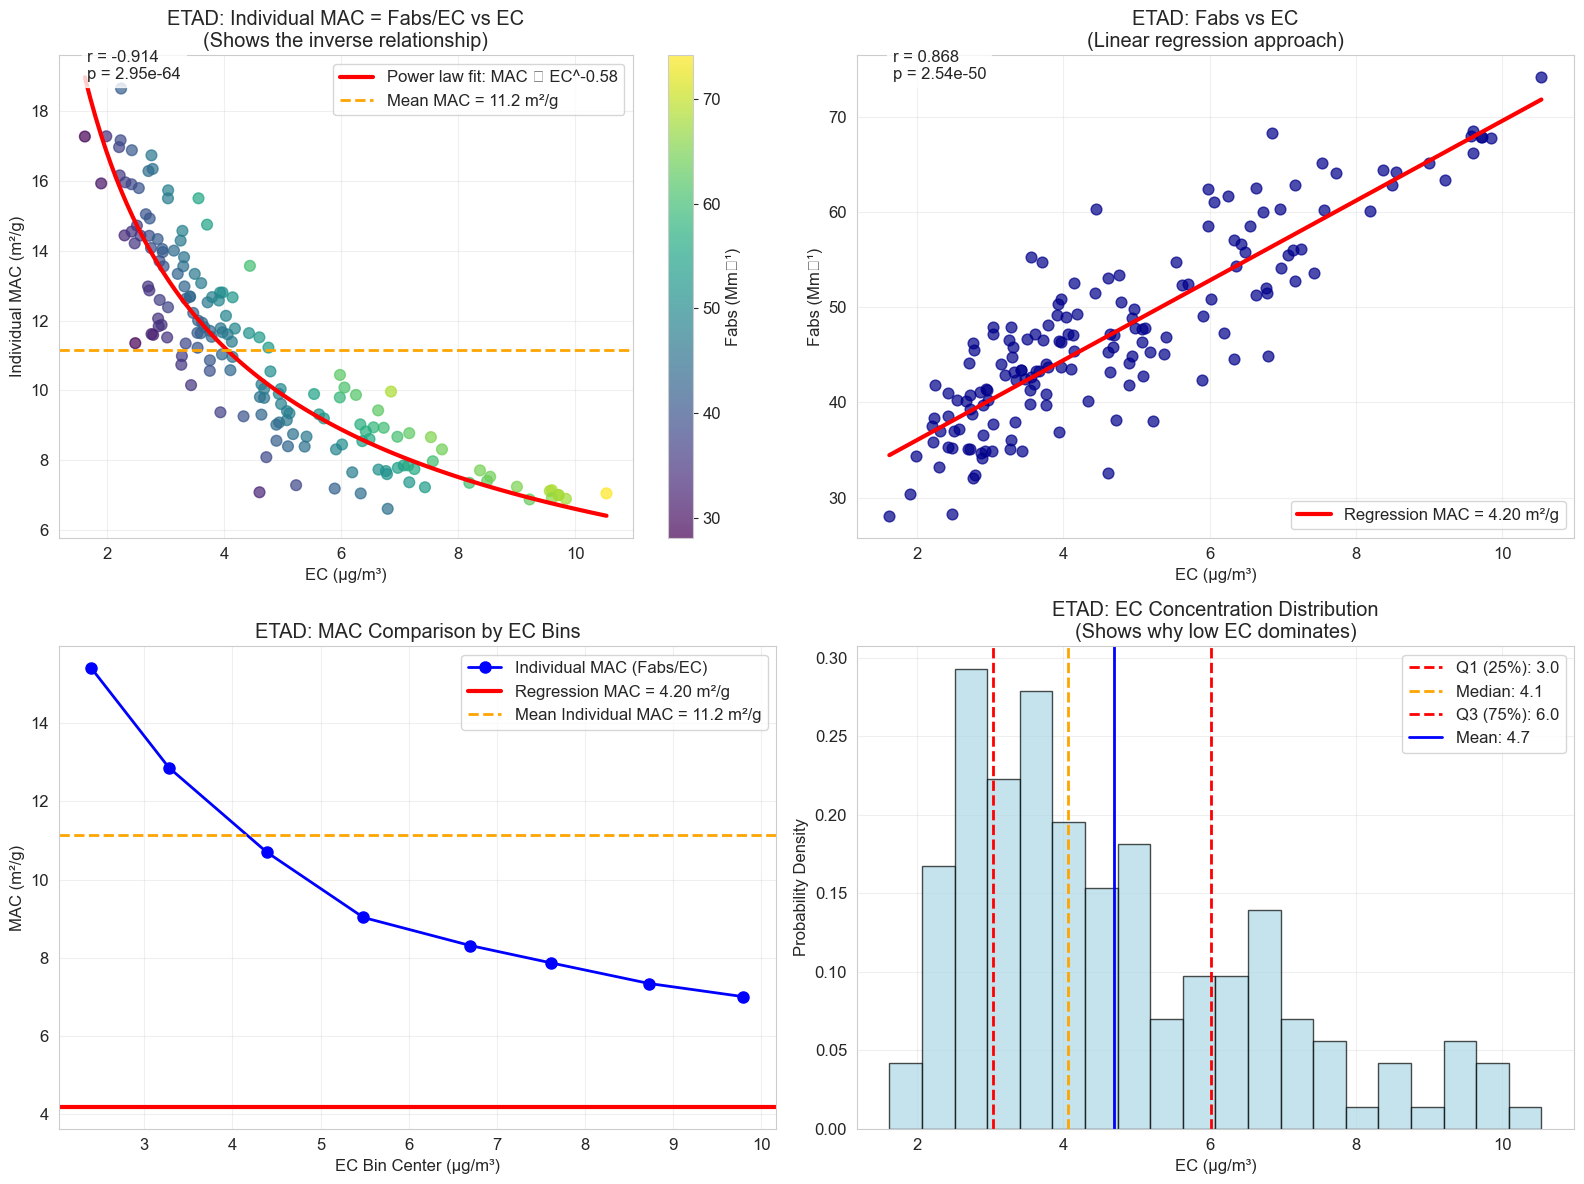


===== ETAD: MAC vs EC Relationship Analysis =====

--- Why Individual MAC is Higher ---
EC distribution is skewed toward LOW values:
  • 25% of samples have EC < 3.0 μg/m³
  • 50% of samples have EC < 4.1 μg/m³
  • 75% of samples have EC < 6.0 μg/m³

MAC values are INVERSELY related to EC:
  • Power law: MAC ∝ EC^-0.58 (negative exponent!)
  • Low EC samples get HIGH MAC weights in the average
  • High EC samples get LOW MAC weights in the average

Result:
  • Individual MAC average: 11.15 m²/g (dominated by low EC)
  • Regression MAC: 4.20 m²/g (represents overall trend)

Contribution by EC quartile:
  • Q1 (EC~2.6): MAC=14.6 m²/g, n=41, contributes 3.7 to average
  • Q2 (EC~3.6): MAC=12.3 m²/g, n=40, contributes 3.1 to average
  • Q3 (EC~5.0): MAC=9.7 m²/g, n=40, contributes 2.4 to average
  • Q4 (EC~7.6): MAC=7.9 m²/g, n=40, contributes 2.0 to average


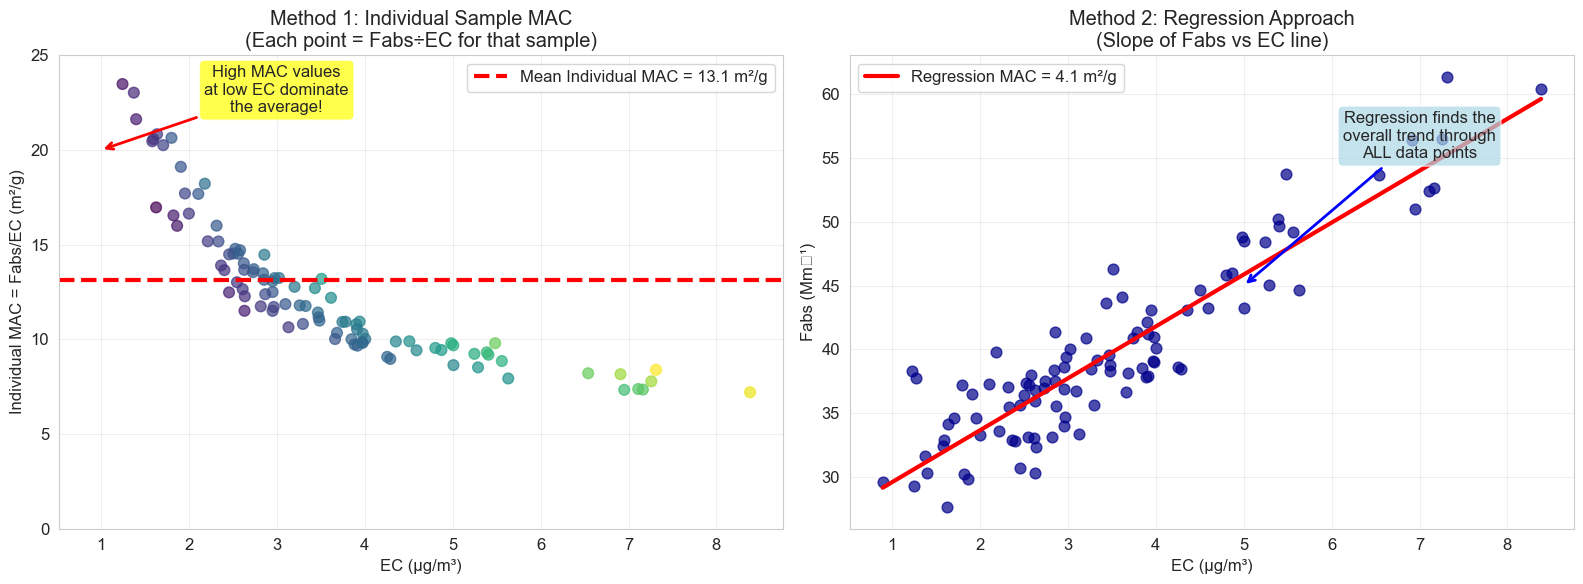

🎯 Key Insight:
Individual MAC method: 13.1 m²/g (influenced by low-EC samples)
Regression MAC method: 4.1 m²/g (robust overall trend)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

def visualize_mac_ec_relationship(df, site_code):
    """
    Create comprehensive visualization showing why individual MAC calculations 
    differ from regression MAC estimates
    """
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Calculate individual MAC values
    df['individual_mac'] = df['fabs'] / df['ec_ftir']
    
    # 1. Individual MAC vs EC (the inverse relationship)
    ax1 = axes[0, 0]
    
    # Scatter plot
    scatter = ax1.scatter(df['ec_ftir'], df['individual_mac'], 
                         c=df['fabs'], s=60, alpha=0.7, cmap='viridis')
    
    # Fit and plot inverse relationship curve
    # Using power law: MAC = a * EC^b (where b should be negative)
    log_ec = np.log(df['ec_ftir'])
    log_mac = np.log(df['individual_mac'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_ec, log_mac)
    
    # Generate smooth curve
    ec_smooth = np.linspace(df['ec_ftir'].min(), df['ec_ftir'].max(), 100)
    mac_smooth = np.exp(intercept) * ec_smooth**slope
    
    ax1.plot(ec_smooth, mac_smooth, 'r-', linewidth=3, 
             label=f'Power law fit: MAC ∝ EC^{slope:.2f}')
    
    # Add horizontal line at mean MAC
    ax1.axhline(df['individual_mac'].mean(), color='orange', linestyle='--', 
                linewidth=2, label=f'Mean MAC = {df["individual_mac"].mean():.1f} m²/g')
    
    ax1.set_xlabel('EC (μg/m³)')
    ax1.set_ylabel('Individual MAC (m²/g)')
    ax1.set_title(f'{site_code}: Individual MAC = Fabs/EC vs EC\n(Shows the inverse relationship)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Fabs (Mm⁻¹)')
    
    # Add text with correlation
    ax1.text(0.05, 0.95, f'r = {r_value:.3f}\np = {p_value:.2e}', 
             transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Fabs vs EC (the regression relationship)
    ax2 = axes[0, 1]
    
    # Scatter plot
    ax2.scatter(df['ec_ftir'], df['fabs'], alpha=0.7, s=60, color='darkblue')
    
    # Linear regression
    slope_reg, intercept_reg = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    ec_line = np.linspace(df['ec_ftir'].min(), df['ec_ftir'].max(), 100)
    fabs_line = slope_reg * ec_line + intercept_reg
    
    ax2.plot(ec_line, fabs_line, 'r-', linewidth=3, 
             label=f'Regression MAC = {slope_reg:.2f} m²/g')
    
    ax2.set_xlabel('EC (μg/m³)')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'{site_code}: Fabs vs EC\n(Linear regression approach)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add correlation
    r_reg, p_reg = stats.pearsonr(df['ec_ftir'], df['fabs'])
    ax2.text(0.05, 0.95, f'r = {r_reg:.3f}\np = {p_reg:.2e}', 
             transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. Comparison of MAC methods by EC bins
    ax3 = axes[1, 0]
    
    # Create EC bins
    n_bins = 8
    df['ec_bin'] = pd.cut(df['ec_ftir'], bins=n_bins)
    
    # Calculate MAC statistics for each bin
    bin_stats = df.groupby('ec_bin').agg({
        'ec_ftir': 'mean',
        'individual_mac': 'mean',
        'fabs': 'mean'
    }).reset_index()
    
    # Calculate regression MAC for each bin center
    bin_stats['regression_mac'] = slope_reg
    
    # Plot
    ax3.plot(bin_stats['ec_ftir'], bin_stats['individual_mac'], 
             'bo-', linewidth=2, markersize=8, label='Individual MAC (Fabs/EC)')
    ax3.axhline(slope_reg, color='red', linestyle='-', linewidth=3, 
                label=f'Regression MAC = {slope_reg:.2f} m²/g')
    ax3.axhline(df['individual_mac'].mean(), color='orange', linestyle='--', 
                linewidth=2, label=f'Mean Individual MAC = {df["individual_mac"].mean():.1f} m²/g')
    
    ax3.set_xlabel('EC Bin Center (μg/m³)')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'{site_code}: MAC Comparison by EC Bins')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Histogram of EC concentrations (to show data distribution)
    ax4 = axes[1, 1]
    
    # Histogram
    n, bins, patches = ax4.hist(df['ec_ftir'], bins=20, alpha=0.7, color='lightblue', 
                               edgecolor='black', density=True)
    
    # Add vertical lines for quartiles
    quartiles = df['ec_ftir'].quantile([0.25, 0.5, 0.75])
    colors = ['red', 'orange', 'red']
    labels = ['Q1 (25%)', 'Median', 'Q3 (75%)']
    
    for q, color, label in zip(quartiles, colors, labels):
        ax4.axvline(q, color=color, linestyle='--', linewidth=2, label=f'{label}: {q:.1f}')
    
    # Add mean
    ax4.axvline(df['ec_ftir'].mean(), color='blue', linestyle='-', linewidth=2, 
                label=f'Mean: {df["ec_ftir"].mean():.1f}')
    
    ax4.set_xlabel('EC (μg/m³)')
    ax4.set_ylabel('Probability Density')
    ax4.set_title(f'{site_code}: EC Concentration Distribution\n(Shows why low EC dominates)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n===== {site_code}: MAC vs EC Relationship Analysis =====")
    print(f"\n--- Why Individual MAC is Higher ---")
    print(f"EC distribution is skewed toward LOW values:")
    print(f"  • 25% of samples have EC < {quartiles[0.25]:.1f} μg/m³")
    print(f"  • 50% of samples have EC < {quartiles[0.5]:.1f} μg/m³")
    print(f"  • 75% of samples have EC < {quartiles[0.75]:.1f} μg/m³")
    
    print(f"\nMAC values are INVERSELY related to EC:")
    print(f"  • Power law: MAC ∝ EC^{slope:.2f} (negative exponent!)")
    print(f"  • Low EC samples get HIGH MAC weights in the average")
    print(f"  • High EC samples get LOW MAC weights in the average")
    
    print(f"\nResult:")
    print(f"  • Individual MAC average: {df['individual_mac'].mean():.2f} m²/g (dominated by low EC)")
    print(f"  • Regression MAC: {slope_reg:.2f} m²/g (represents overall trend)")
    
    # Calculate weighted contribution by EC quartile
    df['ec_quartile'] = pd.qcut(df['ec_ftir'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    quartile_contribution = df.groupby('ec_quartile').agg({
        'individual_mac': ['mean', 'count'],
        'ec_ftir': 'mean'
    }).round(2)
    
    print(f"\nContribution by EC quartile:")
    for q in ['Q1', 'Q2', 'Q3', 'Q4']:
        mac_mean = quartile_contribution.loc[q, ('individual_mac', 'mean')]
        count = quartile_contribution.loc[q, ('individual_mac', 'count')]
        ec_mean = quartile_contribution.loc[q, ('ec_ftir', 'mean')]
        contribution = (mac_mean * count) / len(df)
        print(f"  • {q} (EC~{ec_mean:.1f}): MAC={mac_mean:.1f} m²/g, n={count}, contributes {contribution:.1f} to average")
    
    return bin_stats

def create_conceptual_diagram():
    """
    Create a conceptual diagram showing the difference between methods
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Generate example data
    np.random.seed(42)
    ec_example = np.random.lognormal(mean=1.2, sigma=0.5, size=100)
    ec_example = ec_example[ec_example <= 10]  # Limit range
    
    # Create realistic Fabs values with some noise
    fabs_example = 4.2 * ec_example + 25 + np.random.normal(0, 3, len(ec_example))
    individual_mac_example = fabs_example / ec_example
    
    # Method 1: Individual MAC
    ax1 = axes[0]
    scatter1 = ax1.scatter(ec_example, individual_mac_example, 
                          c=fabs_example, s=60, alpha=0.7, cmap='viridis')
    ax1.axhline(individual_mac_example.mean(), color='red', linestyle='--', 
                linewidth=3, label=f'Mean Individual MAC = {individual_mac_example.mean():.1f} m²/g')
    
    ax1.set_xlabel('EC (μg/m³)')
    ax1.set_ylabel('Individual MAC = Fabs/EC (m²/g)')
    ax1.set_title('Method 1: Individual Sample MAC\n(Each point = Fabs÷EC for that sample)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 25)
    
    # Add annotation for high MAC at low EC
    ax1.annotate('High MAC values\nat low EC dominate\nthe average!', 
                xy=(1, 20), xytext=(3, 22),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=12, ha='center',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # Method 2: Regression
    ax2 = axes[1]
    ax2.scatter(ec_example, fabs_example, alpha=0.7, s=60, color='darkblue')
    
    # Regression line
    slope_ex, intercept_ex = np.polyfit(ec_example, fabs_example, 1)
    ec_line_ex = np.linspace(ec_example.min(), ec_example.max(), 100)
    fabs_line_ex = slope_ex * ec_line_ex + intercept_ex
    
    ax2.plot(ec_line_ex, fabs_line_ex, 'r-', linewidth=3, 
             label=f'Regression MAC = {slope_ex:.1f} m²/g')
    
    ax2.set_xlabel('EC (μg/m³)')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title('Method 2: Regression Approach\n(Slope of Fabs vs EC line)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add annotation for regression robustness
    ax2.annotate('Regression finds the\noverall trend through\nALL data points', 
                xy=(5, 45), xytext=(7, 55),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                fontsize=12, ha='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    print("🎯 Key Insight:")
    print(f"Individual MAC method: {individual_mac_example.mean():.1f} m²/g (influenced by low-EC samples)")
    print(f"Regression MAC method: {slope_ex:.1f} m²/g (robust overall trend)")

# Usage:
bin_stats = visualize_mac_ec_relationship(data_metrics, SITE_OF_INTEREST)
create_conceptual_diagram()

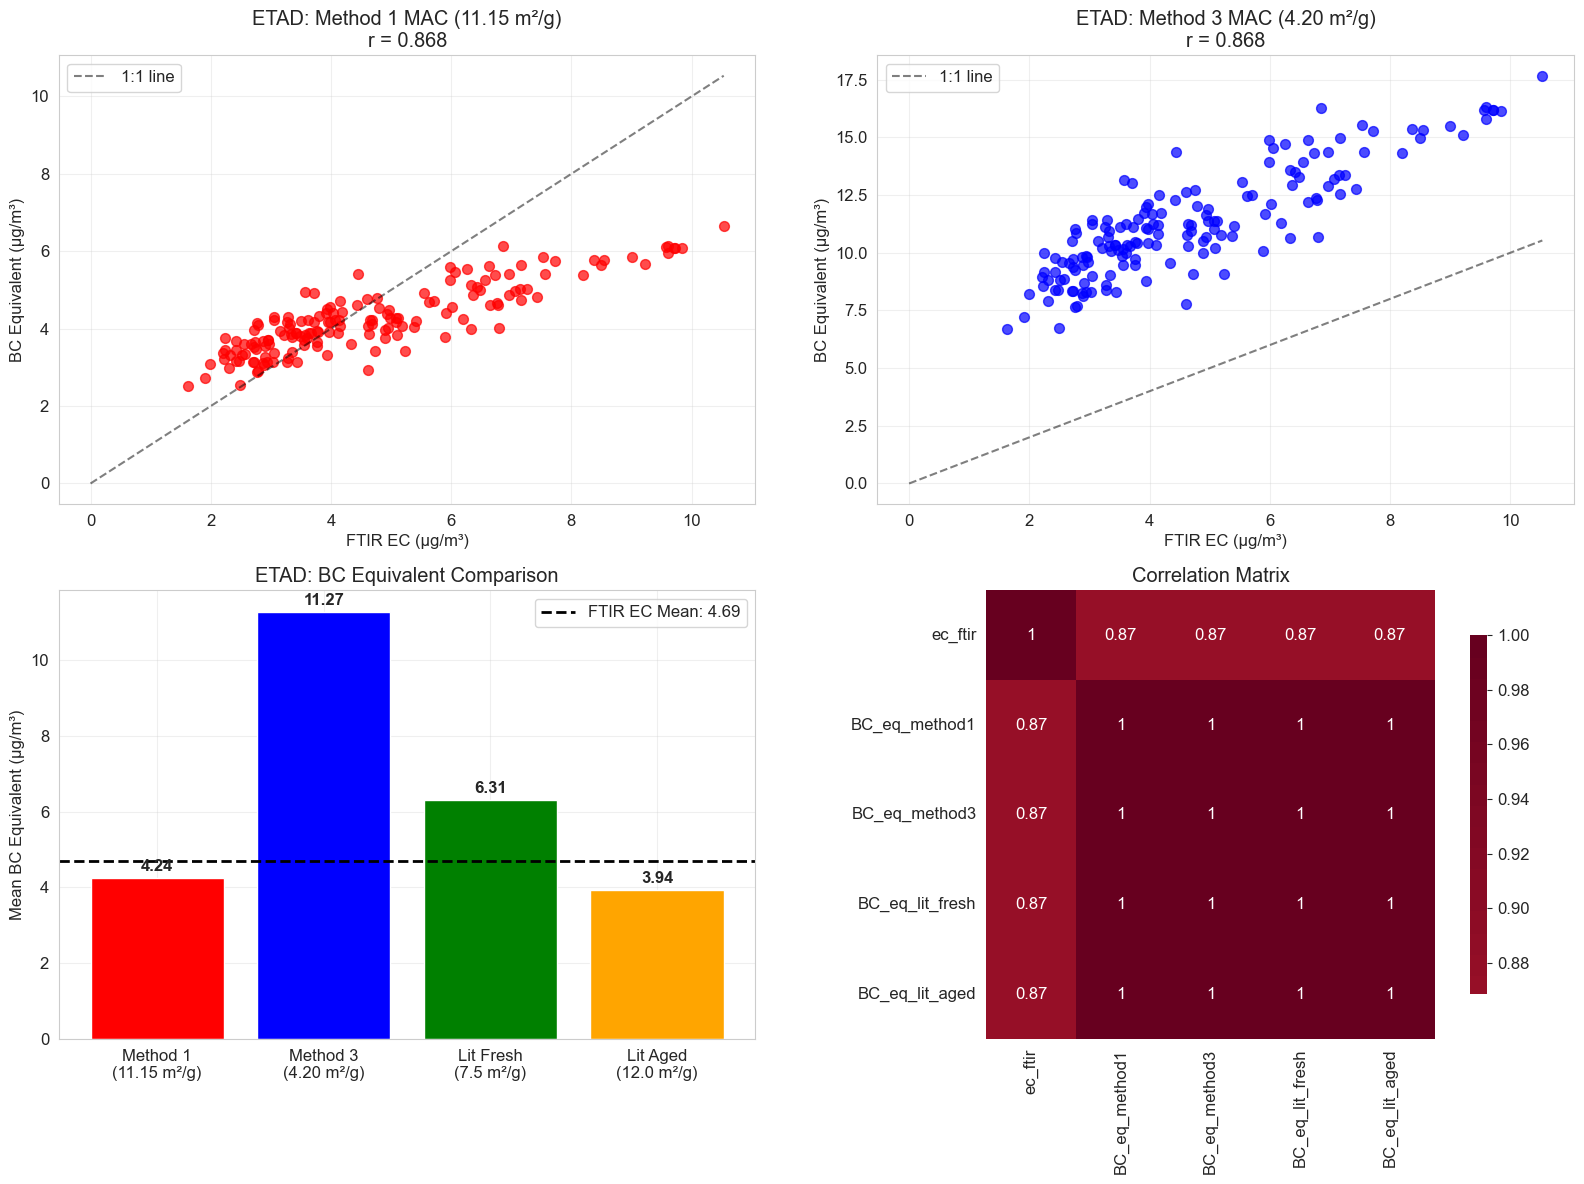


===== BC Equivalent Comparison for ETAD =====

MAC Values Used:
  Method 1 (Site Average):    11.15 m²/g
  Method 3 (Regression):      4.20 m²/g
  Literature Fresh BC:        7.50 m²/g
  Literature Aged BC:         12.00 m²/g

BC Equivalent Results:
  Method 1: 4.24 ± 0.87 μg/m³
  Method 3: 11.27 ± 2.32 μg/m³
  Lit Fresh: 6.31 ± 1.30 μg/m³
  Lit Aged: 3.94 ± 0.81 μg/m³

FTIR EC for comparison: 4.69 ± 2.02 μg/m³

Correlations with FTIR EC:
  Method 1: r = 0.868, p = 2.54e-50
  Method 3: r = 0.868, p = 2.54e-50

Bias vs FTIR EC:
  Method 1: -0.45 μg/m³
  Method 3: 6.58 μg/m³

RMSE vs FTIR EC:
  Method 1: 1.40 μg/m³
  Method 3: 6.68 μg/m³

===== RECOMMENDATION =====
✅ Use Method 1 MAC (11.15 m²/g) for BC equivalent
   - Better correlation with FTIR EC (r = 0.868)
   - Lower bias and RMSE
   - Represents actual atmospheric conditions at ETAD


In [16]:
def compare_bc_equivalent_methods(df, site_code):
    """
    Compare different methods for calculating BC equivalent from HIPS measurements
    
    Parameters:
    -----------
    df : DataFrame
        Data with columns: 'fabs', 'ec_ftir', 'oc_ftir'
    site_code : str
        Site identifier
    
    Returns:
    --------
    Comparison of BC equivalent calculations
    """
    
    # Calculate different MAC values
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()  # Your 11.15 m²/g
    
    # Regression MAC
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope  # Your 4.20 m²/g
    
    # Literature MAC values for comparison
    mac_literature_fresh = 7.5  # Fresh BC from literature
    mac_literature_aged = 12.0  # Aged/coated BC from literature
    
    # Calculate BC equivalents using different MAC values
    df_comparison = df.copy()
    
    df_comparison['BC_eq_method1'] = df_comparison['fabs'] / mac_method1
    df_comparison['BC_eq_method3'] = df_comparison['fabs'] / mac_method3
    df_comparison['BC_eq_lit_fresh'] = df_comparison['fabs'] / mac_literature_fresh
    df_comparison['BC_eq_lit_aged'] = df_comparison['fabs'] / mac_literature_aged
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. BC equivalent vs FTIR EC (Method 1)
    ax1 = axes[0, 0]
    ax1.scatter(df_comparison['ec_ftir'], df_comparison['BC_eq_method1'], 
                alpha=0.7, s=50, color='red')
    ax1.plot([0, df['ec_ftir'].max()], [0, df['ec_ftir'].max()], 
             'k--', alpha=0.5, label='1:1 line')
    
    r1, p1 = stats.pearsonr(df_comparison['ec_ftir'], df_comparison['BC_eq_method1'])
    ax1.set_xlabel('FTIR EC (μg/m³)')
    ax1.set_ylabel('BC Equivalent (μg/m³)')
    ax1.set_title(f'{site_code}: Method 1 MAC ({mac_method1:.2f} m²/g)\nr = {r1:.3f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. BC equivalent vs FTIR EC (Method 3)
    ax2 = axes[0, 1]
    ax2.scatter(df_comparison['ec_ftir'], df_comparison['BC_eq_method3'], 
                alpha=0.7, s=50, color='blue')
    ax2.plot([0, df['ec_ftir'].max()], [0, df['ec_ftir'].max()], 
             'k--', alpha=0.5, label='1:1 line')
    
    r3, p3 = stats.pearsonr(df_comparison['ec_ftir'], df_comparison['BC_eq_method3'])
    ax2.set_xlabel('FTIR EC (μg/m³)')
    ax2.set_ylabel('BC Equivalent (μg/m³)')
    ax2.set_title(f'{site_code}: Method 3 MAC ({mac_method3:.2f} m²/g)\nr = {r3:.3f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Comparison of all BC equivalent methods
    ax3 = axes[1, 0]
    methods = ['Method 1\n(11.15 m²/g)', 'Method 3\n(4.20 m²/g)', 
               'Lit Fresh\n(7.5 m²/g)', 'Lit Aged\n(12.0 m²/g)']
    bc_means = [df_comparison['BC_eq_method1'].mean(),
                df_comparison['BC_eq_method3'].mean(),
                df_comparison['BC_eq_lit_fresh'].mean(),
                df_comparison['BC_eq_lit_aged'].mean()]
    
    bars = ax3.bar(methods, bc_means, color=['red', 'blue', 'green', 'orange'])
    ax3.set_ylabel('Mean BC Equivalent (μg/m³)')
    ax3.set_title(f'{site_code}: BC Equivalent Comparison')
    ax3.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, value in zip(bars, bc_means):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Add FTIR EC mean line for reference
    ec_mean = df['ec_ftir'].mean()
    ax3.axhline(ec_mean, color='black', linestyle='--', linewidth=2,
                label=f'FTIR EC Mean: {ec_mean:.2f}')
    ax3.legend()
    
    # 4. Correlation matrix
    ax4 = axes[1, 1]
    
    corr_data = df_comparison[['ec_ftir', 'BC_eq_method1', 'BC_eq_method3', 
                               'BC_eq_lit_fresh', 'BC_eq_lit_aged']].corr()
    
    sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0, 
                square=True, ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\n===== BC Equivalent Comparison for {site_code} =====")
    print(f"\nMAC Values Used:")
    print(f"  Method 1 (Site Average):    {mac_method1:.2f} m²/g")
    print(f"  Method 3 (Regression):      {mac_method3:.2f} m²/g")
    print(f"  Literature Fresh BC:        {mac_literature_fresh:.2f} m²/g")
    print(f"  Literature Aged BC:         {mac_literature_aged:.2f} m²/g")
    
    print(f"\nBC Equivalent Results:")
    print(f"  Method 1: {df_comparison['BC_eq_method1'].mean():.2f} ± {df_comparison['BC_eq_method1'].std():.2f} μg/m³")
    print(f"  Method 3: {df_comparison['BC_eq_method3'].mean():.2f} ± {df_comparison['BC_eq_method3'].std():.2f} μg/m³")
    print(f"  Lit Fresh: {df_comparison['BC_eq_lit_fresh'].mean():.2f} ± {df_comparison['BC_eq_lit_fresh'].std():.2f} μg/m³")
    print(f"  Lit Aged: {df_comparison['BC_eq_lit_aged'].mean():.2f} ± {df_comparison['BC_eq_lit_aged'].std():.2f} μg/m³")
    
    print(f"\nFTIR EC for comparison: {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    
    print(f"\nCorrelations with FTIR EC:")
    print(f"  Method 1: r = {r1:.3f}, p = {p1:.3g}")
    print(f"  Method 3: r = {r3:.3f}, p = {p3:.3g}")
    
    # Calculate bias and RMSE
    bias1 = (df_comparison['BC_eq_method1'] - df_comparison['ec_ftir']).mean()
    bias3 = (df_comparison['BC_eq_method3'] - df_comparison['ec_ftir']).mean()
    
    rmse1 = np.sqrt(((df_comparison['BC_eq_method1'] - df_comparison['ec_ftir'])**2).mean())
    rmse3 = np.sqrt(((df_comparison['BC_eq_method3'] - df_comparison['ec_ftir'])**2).mean())
    
    print(f"\nBias vs FTIR EC:")
    print(f"  Method 1: {bias1:.2f} μg/m³")
    print(f"  Method 3: {bias3:.2f} μg/m³")
    
    print(f"\nRMSE vs FTIR EC:")
    print(f"  Method 1: {rmse1:.2f} μg/m³")
    print(f"  Method 3: {rmse3:.2f} μg/m³")
    
    # Recommendation
    print(f"\n===== RECOMMENDATION =====")
    if abs(bias1) < abs(bias3) and rmse1 < rmse3:
        print(f"✅ Use Method 1 MAC ({mac_method1:.2f} m²/g) for BC equivalent")
        print(f"   - Better correlation with FTIR EC (r = {r1:.3f})")
        print(f"   - Lower bias and RMSE")
        print(f"   - Represents actual atmospheric conditions at {site_code}")
    else:
        print(f"✅ Use Method 3 MAC ({mac_method3:.2f} m²/g) for BC equivalent")
        print(f"   - Better correlation with FTIR EC (r = {r3:.3f})")
        print(f"   - Lower bias and RMSE")
        print(f"   - More comparable to literature values")
    
    return df_comparison

# Usage:
bc_comparison = compare_bc_equivalent_methods(data_metrics, SITE_OF_INTEREST)

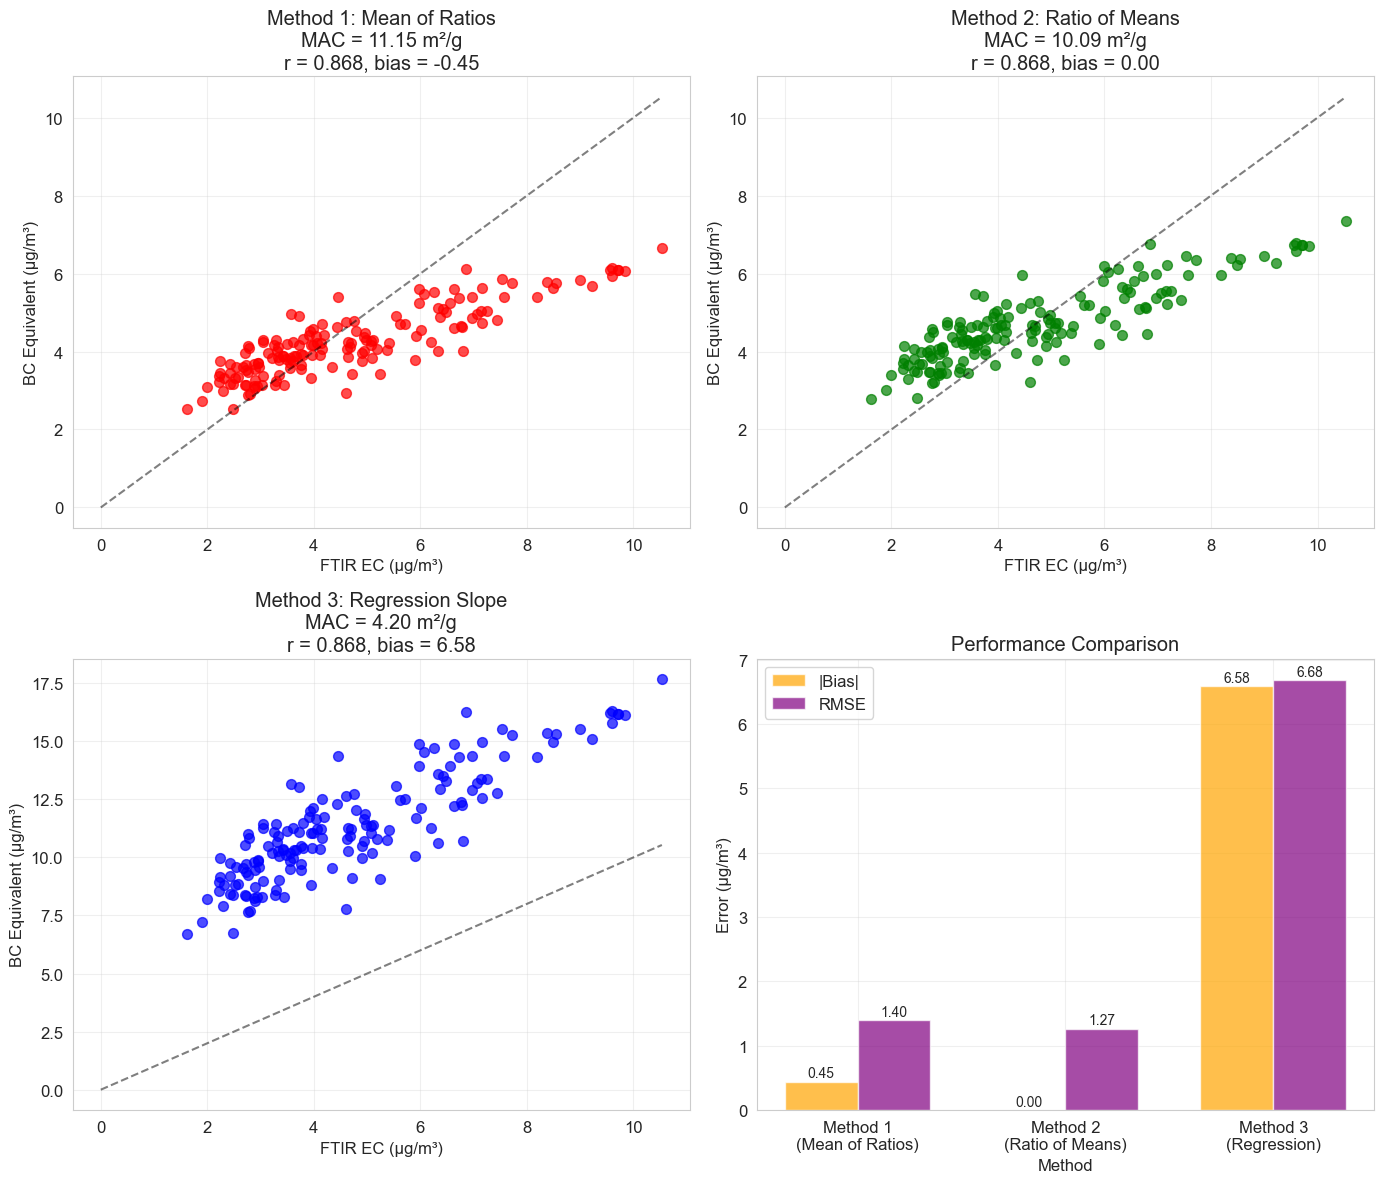


===== Complete MAC Method Comparison for ETAD =====

MAC Values:
  Method 1 (Mean of Ratios):  11.15 m²/g
  Method 2 (Ratio of Means):  10.09 m²/g
  Method 3 (Regression):      4.20 m²/g

BC Equivalent Means:
  Method 1: 4.24 ± 0.87 μg/m³
  Method 2: 4.69 ± 0.97 μg/m³
  Method 3: 11.27 ± 2.32 μg/m³
  FTIR EC:  4.69 ± 2.02 μg/m³

Performance Metrics:
Method          Correlation  Bias       RMSE      
Method 1        0.868        -0.45      1.40      
Method 2        0.868        0.00       1.27      
Method 3        0.868        6.58       6.68      

===== METHOD RANKING (Best to Worst) =====
1. Method 2: MAC = 10.09 m²/g
   Performance: r = 0.868, |bias| = 0.00, RMSE = 1.27
   ✅ RECOMMENDED for BC equivalent calculations

2. Method 1: MAC = 11.15 m²/g
   Performance: r = 0.868, |bias| = 0.45, RMSE = 1.40

3. Method 3: MAC = 4.20 m²/g
   Performance: r = 0.868, |bias| = 6.58, RMSE = 6.68

===== PRACTICAL IMPLICATIONS =====
For a typical Fabs = 45 Mm⁻¹:
  Method 1: BC = 45/11.15 = 4.04

In [17]:
def analyze_method2_performance(df, site_code):
    """
    Analyze Method 2 (ratio of means) performance for BC equivalent calculations
    
    Parameters:
    -----------
    df : DataFrame
        Data with 'fabs', 'ec_ftir' columns
    site_code : str
        Site identifier
    """
    
    # Calculate all MAC values
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()  # Mean of ratios: 11.15 m²/g
    
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()  # Ratio of means
    
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope  # Regression: 4.20 m²/g
    
    # Calculate BC equivalents
    bc_method1 = df['fabs'] / mac_method1
    bc_method2 = df['fabs'] / mac_method2
    bc_method3 = df['fabs'] / mac_method3
    
    # Calculate performance metrics
    def calc_metrics(bc_equiv, ftir_ec):
        correlation = stats.pearsonr(bc_equiv, ftir_ec)[0]
        bias = (bc_equiv - ftir_ec).mean()
        rmse = np.sqrt(((bc_equiv - ftir_ec)**2).mean())
        return correlation, bias, rmse
    
    corr1, bias1, rmse1 = calc_metrics(bc_method1, df['ec_ftir'])
    corr2, bias2, rmse2 = calc_metrics(bc_method2, df['ec_ftir'])
    corr3, bias3, rmse3 = calc_metrics(bc_method3, df['ec_ftir'])
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Method 1
    ax1 = axes[0, 0]
    ax1.scatter(df['ec_ftir'], bc_method1, alpha=0.7, color='red', s=50)
    ax1.plot([0, df['ec_ftir'].max()], [0, df['ec_ftir'].max()], 'k--', alpha=0.5)
    ax1.set_xlabel('FTIR EC (μg/m³)')
    ax1.set_ylabel('BC Equivalent (μg/m³)')
    ax1.set_title(f'Method 1: Mean of Ratios\nMAC = {mac_method1:.2f} m²/g\nr = {corr1:.3f}, bias = {bias1:.2f}')
    ax1.grid(True, alpha=0.3)
    
    # Method 2
    ax2 = axes[0, 1]
    ax2.scatter(df['ec_ftir'], bc_method2, alpha=0.7, color='green', s=50)
    ax2.plot([0, df['ec_ftir'].max()], [0, df['ec_ftir'].max()], 'k--', alpha=0.5)
    ax2.set_xlabel('FTIR EC (μg/m³)')
    ax2.set_ylabel('BC Equivalent (μg/m³)')
    ax2.set_title(f'Method 2: Ratio of Means\nMAC = {mac_method2:.2f} m²/g\nr = {corr2:.3f}, bias = {bias2:.2f}')
    ax2.grid(True, alpha=0.3)
    
    # Method 3
    ax3 = axes[1, 0]
    ax3.scatter(df['ec_ftir'], bc_method3, alpha=0.7, color='blue', s=50)
    ax3.plot([0, df['ec_ftir'].max()], [0, df['ec_ftir'].max()], 'k--', alpha=0.5)
    ax3.set_xlabel('FTIR EC (μg/m³)')
    ax3.set_ylabel('BC Equivalent (μg/m³)')
    ax3.set_title(f'Method 3: Regression Slope\nMAC = {mac_method3:.2f} m²/g\nr = {corr3:.3f}, bias = {bias3:.2f}')
    ax3.grid(True, alpha=0.3)
    
    # Performance comparison
    ax4 = axes[1, 1]
    methods = ['Method 1\n(Mean of Ratios)', 'Method 2\n(Ratio of Means)', 'Method 3\n(Regression)']
    mac_values = [mac_method1, mac_method2, mac_method3]
    bias_values = [abs(bias1), abs(bias2), abs(bias3)]
    rmse_values = [rmse1, rmse2, rmse3]
    
    x = np.arange(len(methods))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, bias_values, width, label='|Bias|', color='orange', alpha=0.7)
    bars2 = ax4.bar(x + width/2, rmse_values, width, label='RMSE', color='purple', alpha=0.7)
    
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Error (μg/m³)')
    ax4.set_title('Performance Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, value in zip(bars1, bias_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    for bar, value in zip(bars2, rmse_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed comparison
    print(f"\n===== Complete MAC Method Comparison for {site_code} =====")
    print(f"\nMAC Values:")
    print(f"  Method 1 (Mean of Ratios):  {mac_method1:.2f} m²/g")
    print(f"  Method 2 (Ratio of Means):  {mac_method2:.2f} m²/g")
    print(f"  Method 3 (Regression):      {mac_method3:.2f} m²/g")
    
    print(f"\nBC Equivalent Means:")
    print(f"  Method 1: {bc_method1.mean():.2f} ± {bc_method1.std():.2f} μg/m³")
    print(f"  Method 2: {bc_method2.mean():.2f} ± {bc_method2.std():.2f} μg/m³")
    print(f"  Method 3: {bc_method3.mean():.2f} ± {bc_method3.std():.2f} μg/m³")
    print(f"  FTIR EC:  {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    
    print(f"\nPerformance Metrics:")
    print(f"{'Method':<15} {'Correlation':<12} {'Bias':<10} {'RMSE':<10}")
    print(f"{'='*50}")
    print(f"{'Method 1':<15} {corr1:<12.3f} {bias1:<10.2f} {rmse1:<10.2f}")
    print(f"{'Method 2':<15} {corr2:<12.3f} {bias2:<10.2f} {rmse2:<10.2f}")
    print(f"{'Method 3':<15} {corr3:<12.3f} {bias3:<10.2f} {rmse3:<10.2f}")
    
    # Rank methods
    methods_data = [
        ('Method 1', mac_method1, corr1, abs(bias1), rmse1),
        ('Method 2', mac_method2, corr2, abs(bias2), rmse2),
        ('Method 3', mac_method3, corr3, abs(bias3), rmse3)
    ]
    
    # Sort by combined performance (lower bias + lower RMSE = better)
    methods_ranked = sorted(methods_data, key=lambda x: x[3] + x[4])  # bias + rmse
    
    print(f"\n===== METHOD RANKING (Best to Worst) =====")
    for i, (method, mac, corr, bias, rmse) in enumerate(methods_ranked, 1):
        print(f"{i}. {method}: MAC = {mac:.2f} m²/g")
        print(f"   Performance: r = {corr:.3f}, |bias| = {bias:.2f}, RMSE = {rmse:.2f}")
        
        if i == 1:
            print(f"   ✅ RECOMMENDED for BC equivalent calculations")
        print()
    
    # Practical implications
    print(f"===== PRACTICAL IMPLICATIONS =====")
    print(f"For a typical Fabs = 45 Mm⁻¹:")
    print(f"  Method 1: BC = 45/{mac_method1:.2f} = {45/mac_method1:.2f} μg/m³")
    print(f"  Method 2: BC = 45/{mac_method2:.2f} = {45/mac_method2:.2f} μg/m³")
    print(f"  Method 3: BC = 45/{mac_method3:.2f} = {45/mac_method3:.2f} μg/m³")
    
    return {
        'mac_method1': mac_method1,
        'mac_method2': mac_method2, 
        'mac_method3': mac_method3,
        'performance': methods_ranked
    }

# Usage:
method_comparison = analyze_method2_performance(data_metrics, SITE_OF_INTEREST)